<a href="https://colab.research.google.com/github/alcosoda/World-death-analysis/blob/main/World_death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Здравствуйте! В этом ноутбуке содержится работа команды БОГАТЫЕ ФИЧИ ФУРЬЕ.

Выбранный нами датасет предполагает не совсем классический подход к применению машинного обучения, однако(!) на этих данных мы сможем поупражняться в применении множества статистических методов: декомпозиция временных рядов, применение фич фурье различных степеней, критерии схожести распределений и многое другое.

Желаем приятного просмотра!

### Импорты библиотек

In [2]:
!pip install catboost
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=43718f11ae53195bfa93179de3f3684d21345e2af8766405083ef21435ad8782
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
import shap
from lime.lime_tabular import LimeTabularExplainer
from catboost import CatBoostRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from tqdm.notebook import tqdm

In [ ]:
shap.initjs()

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("madhurpant/world-deaths-and-causes-1990-2019")

print(path)

100%|██████████| 442k/442k [00:00<00:00, 44.3MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/madhurpant/world-deaths-and-causes-1990-2019/versions/1


# Сама работа

##

## Чекпоинт 1

### Исследование данных

In [5]:
import os
data = pd.read_csv(os.path.join(path, "annual_deaths_by_causes.csv"))

In [11]:
data

country code  year  meningitis  alzheimer's_diesease  \
0     Afghanistan  AFG  2007      2933.0                1402.0   
1     Afghanistan  AFG  2008      2731.0                1424.0   
2     Afghanistan  AFG  2009      2460.0                1449.0   
3     Afghanistan  AFG  2011      2327.0                1508.0   
4     Afghanistan  AFG  2012      2254.0                1544.0   
...           ...  ...   ...         ...                   ...   
7268     Zimbabwe  ZWE  2015      1439.0                 754.0   
7269     Zimbabwe  ZWE  2016      1457.0                 767.0   
7270     Zimbabwe  ZWE  2017      1460.0                 781.0   
7271     Zimbabwe  ZWE  2018      1450.0                 795.0   
7272     Zimbabwe  ZWE  2019      1450.0                 812.0   

      parkinson's_disease  nutritional_deficiency  malaria  drowning  \
0                   450.0                  2488.0    393.0    2127.0   
1                   455.0                  2277.0    255.0    1973.0   
2                   460.0                  2040.0    239.0    1852.0   
3                   473.0                  1846.0    390.0    1775.0   
4                   482.0                  1705.0     94.0    1716.0   
...                   ...                     ...      ...       ...   
7268                215.0                  3019.0   2518.0     770.0   
7269                219.0                  3056.0   2050.0     801.0   
7270                223.0                  2990.0   2116.0     818.0   
7271                227.0                  2918.0   2088.0     825.0   
7272                232.0                  2884.0   2068.0     827.0   

      interpersonal_violence  ...  chronic_kidney_disease  poisonings  \
0                     3657.0  ...                  4490.0       512.0   
1                     3785.0  ...                  4534.0       495.0   
2                     3874.0  ...                  4597.0       483.0   
3                     4170.0  ...                  4785.0       483.0   
4                     4245.0  ...                  4846.0       482.0   
...                      ...  ...                     ...         ...   
7268                  1302.0  ...                  2108.0       381.0   
7269                  1342.0  ...                  2160.0       393.0   
7270                  1363.0  ...                  2196.0       398.0   
7271                  1396.0  ...                  2240.0       400.0   
7272                  1434.0  ...                  2292.0       405.0   

      protein_energy_malnutrition  terrorism  road_injuries  \
0                          2439.0     1199.0         7425.0   
1                          2231.0     1092.0         7355.0   
2                          1998.0     1065.0         7290.0   
3                          1805.0     1525.0         7432.0   
4                          1667.0     3521.0         7494.0   
...                           ...        ...            ...   
7268                       2990.0        NaN         2373.0   
7269                       3027.0        NaN         2436.0   
7270                       2962.0        0.0         2473.0   
7271                       2890.0        NaN         2509.0   
7272                       2855.0        NaN         2554.0   

      chronic_respiratory_diseases  chronic_liver_diseases  \
0                           7222.0                  3346.0   
1                           7143.0                  3316.0   
2                           7045.0                  3291.0   
3                           6916.0                  3318.0   
4                           6878.0                  3353.0   
...                            ...                     ...   
7268                        2751.0                  1956.0   
7269                        2788.0                  1962.0   
7270                        2818.0                  2007.0   
7271                        2849.0                  2030.0   
7272                        2891.0  

In [15]:
data['country'].nunique()

261

In [21]:
data.columns

Index(['country', 'code', 'year', 'meningitis', 'alzheimer's_diesease',
       'parkinson's_disease', 'nutritional_deficiency', 'malaria', 'drowning',
       'interpersonal_violence', 'maternal_disorders', 'hiv/aids',
       'drug_use_disorders', 'tuberculosis', 'cardiovascular_diseases',
       'lower_respiratory_infections', 'neonatal_disorders',
       'alcohol_use_disorders', 'self_harm', 'exposure_to_forces_of_nature',
       'diarrheal_diseases', 'environmental_heat_and_cold_exposure',
       'neoplasms', 'conflict_and_terrorism', 'diabetes_mellitus',
       'chronic_kidney_disease', 'poisonings', 'protein_energy_malnutrition',
       'terrorism', 'road_injuries', 'chronic_respiratory_diseases',
       'chronic_liver_diseases', 'digestive_diseases',
       'fire_heat_hot_substance', 'acute_hepatitis'],
      dtype='object')

In [6]:
print("Размер датасета:", data.shape)

Размер датасета: (7273, 35)


In [8]:
data.describe()

year     meningitis  alzheimer's_diesease  parkinson's_disease  \
count  7273.000000    6840.000000          6.840000e+03          6840.000000   
mean   2004.425134    8213.149561          2.736319e+04          6493.627339   
std       8.623572   34982.933895          1.113146e+05         25767.447063   
min    1990.000000       0.000000          0.000000e+00             0.000000   
25%    1997.000000      19.000000          1.287500e+02            37.000000   
50%    2004.000000     150.500000          8.455000e+02           209.000000   
75%    2012.000000    1622.250000          4.251000e+03           984.000000   
max    2019.000000  432524.000000          1.623276e+06        362907.000000   

       nutritional_deficiency        malaria       drowning  \
count             6840.000000    6840.000000    6840.000000   
mean             11006.353947   18903.160234    8619.055117   
std              48289.687100   97346.780570   35879.406010   
min                  0.000000       0.000000       0.000000   
25%                 11.000000       0.000000      39.000000   
50%                159.000000       0.000000     253.000000   
75%               2204.000000    1017.250000    1014.250000   
max             757152.000000  961129.000000  460665.000000   

       interpersonal_violence  maternal_disorders      hiv/aids  ...  \
count             6840.000000         6840.000000  6.840000e+03  ...   
mean             10636.648684         6131.066959  2.814125e+04  ...   
std              40888.793762        26355.210370  1.391973e+05  ...   
min                  0.000000            0.000000  0.000000e+00  ...   
25%                 48.000000            6.000000  1.400000e+01  ...   
50%                342.000000           70.500000  1.870000e+02  ...   
75%               1391.250000         1244.500000  3.836500e+03  ...   
max             463129.000000       302586.000000  1.844490e+06  ...   

       chronic_kidney_disease    poisonings  protein_energy_malnutrition  \
count            6.840000e+03   6840.000000                  6840.000000   
mean             2.506893e+04   2145.455848                  9531.528801   
std              9.600839e+04   8433.507625                 41689.675155   
min              0.000000e+00      0.000000                     0.000000   
25%              2.140000e+02      8.000000                     6.000000   
50%              1.080000e+03     72.000000                   120.000000   
75%              4.497500e+03    371.000000                  2120.000000   
max              1.427232e+06  92101.000000                656314.000000   

          terrorism  road_injuries  chronic_respiratory_diseases  \
count   2891.000000   6.840000e+03                  6.840000e+03   
mean     349.235905   3.063496e+04                  9.130390e+04   
std     1917.143788   1.166999e+05                  3.772013e+05   
min        0.000000   0.000000e+00                  1.000000e+00   
25%        0.000000   2.077500e+02                  3.685000e+02   
50%        5.000000   1.239500e+03                  2.104000e+03   
75%       60.000000   5.786250e+03                  9.013250e+03   
max    44490.000000   1.285039e+06                  3.974315e+06   

       chronic_liver_diseases  digestive_diseases  fire_heat_hot_substance  \
count            6.840000e+03        6.840000e+03              6840.000000   
mean             3.189892e+04        5.652551e+04              3006.043275   
std              1.194387e+05        2.109884e+05             11211.885249   
min              0.000000e+00        0.000000e+00                 0.000000   
25%              2.047500e+02        4.000000e+02                21.000000   
50%              1.541000e+03        2.778500e+03               152.000000   
75%              5.670500e+03        9.594000e+03               593.250000   
max              1.472012e+06        2.557689e+06            129705.000000   

       acute_hepatitis  
count      6840.000000  
mean       3112.066520  


In [9]:
data.isna().sum()

country                                    0
code                                    1067
year                                       0
meningitis                               433
alzheimer's_diesease                     433
parkinson's_disease                      433
nutritional_deficiency                   433
malaria                                  433
drowning                                 433
interpersonal_violence                   433
maternal_disorders                       433
hiv/aids                                 433
drug_use_disorders                       433
tuberculosis                             433
cardiovascular_diseases                  433
lower_respiratory_infections             433
neonatal_disorders                       433
alcohol_use_disorders                    433
self_harm                                433
exposure_to_forces_of_nature             433
diarrheal_diseases                       433
environmental_heat_and_cold_exposure     433
neoplasms                                433
conflict_and_terrorism                   433
diabetes_mellitus                        433
chronic_kidney_disease                   433
poisonings                               433
protein_energy_malnutrition              433
terrorism                               4382
road_injuries                            433
chronic_respiratory_diseases             433
chronic_liver_diseases                   433
digestive_diseases                       433
fire_heat_hot_substance                  433
acute_hepatitis                          433
dtype: int64

Пропуски в коде страны для нас не имеют значения, так как для решения нашей задачи нам не важно какой 3-буквенный код у страны, от этого столбца надо будет избавиться при обучении модели. Посмотрим на столбец с аномально большым кол-во пропусков - столбец со смертями про терроризм. Далее попытаемся понять, почему так много столбцов имеют по 433 пропусков.

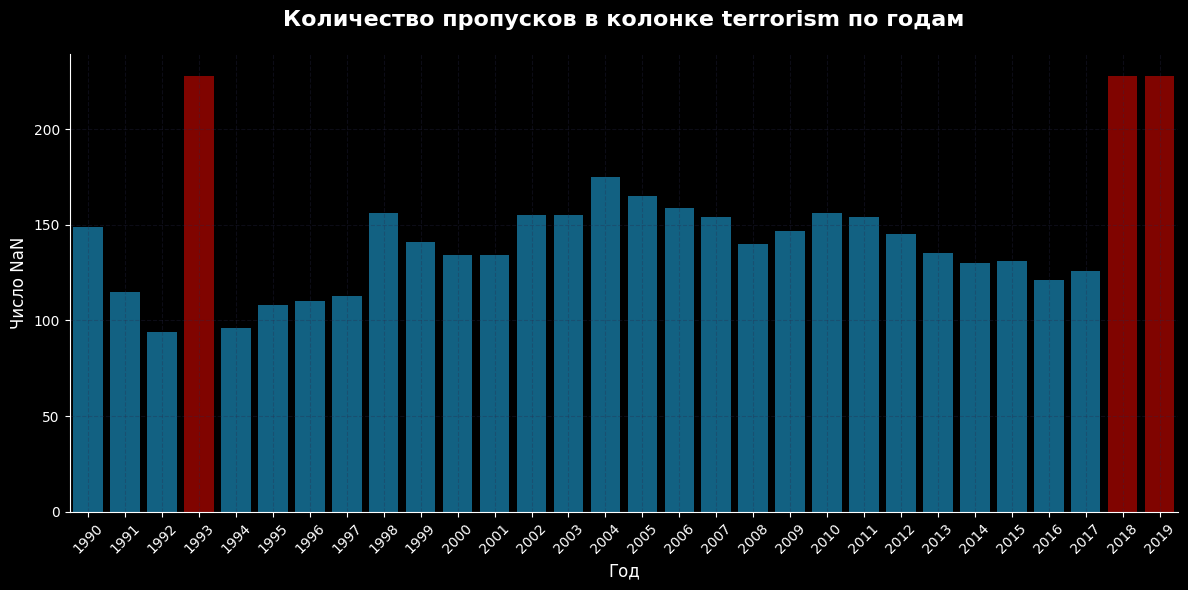

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Work Sans', 'DejaVu Sans']

COLORS = {
    'primary': '#006994',
    'accent': '#800400',
    'text': '#FFFFFF',
    'grid': '#2A2A4A'
}

nan_by_year_terrorism = data.groupby('year')['terrorism'].apply(lambda x: x.isnull().sum()).reset_index()

top_3 = nan_by_year_terrorism.nlargest(3, 'terrorism')

plt.figure(figsize=(12, 6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

bars = sns.barplot(
    data=nan_by_year_terrorism,
    x='year',
    y='terrorism',
    color=COLORS['primary'],
    ax=ax
)

for idx, bar in enumerate(bars.patches):
    year_value = nan_by_year_terrorism.iloc[idx]['year']
    if year_value in top_3['year'].values:
        bar.set_facecolor(COLORS['accent'])

ax.set_title('Количество пропусков в колонке terrorism по годам', color=COLORS['text'], fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Год', color=COLORS['text'], fontsize=12)
ax.set_ylabel('Число NaN', color=COLORS['text'], fontsize=12)

ax.tick_params(axis='x', colors=COLORS['text'], rotation=45)
ax.tick_params(axis='y', colors=COLORS['text'])

ax.spines['bottom'].set_color(COLORS['text'])
ax.spines['left'].set_color(COLORS['text'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True, color=COLORS['grid'], alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Была гипотеза, что данные начали собирать с какого-то года, но теперь есть гипотеза, что NaN в данный столбец ставили, когда невозможно было оценить кол-во смертей по данной причине.

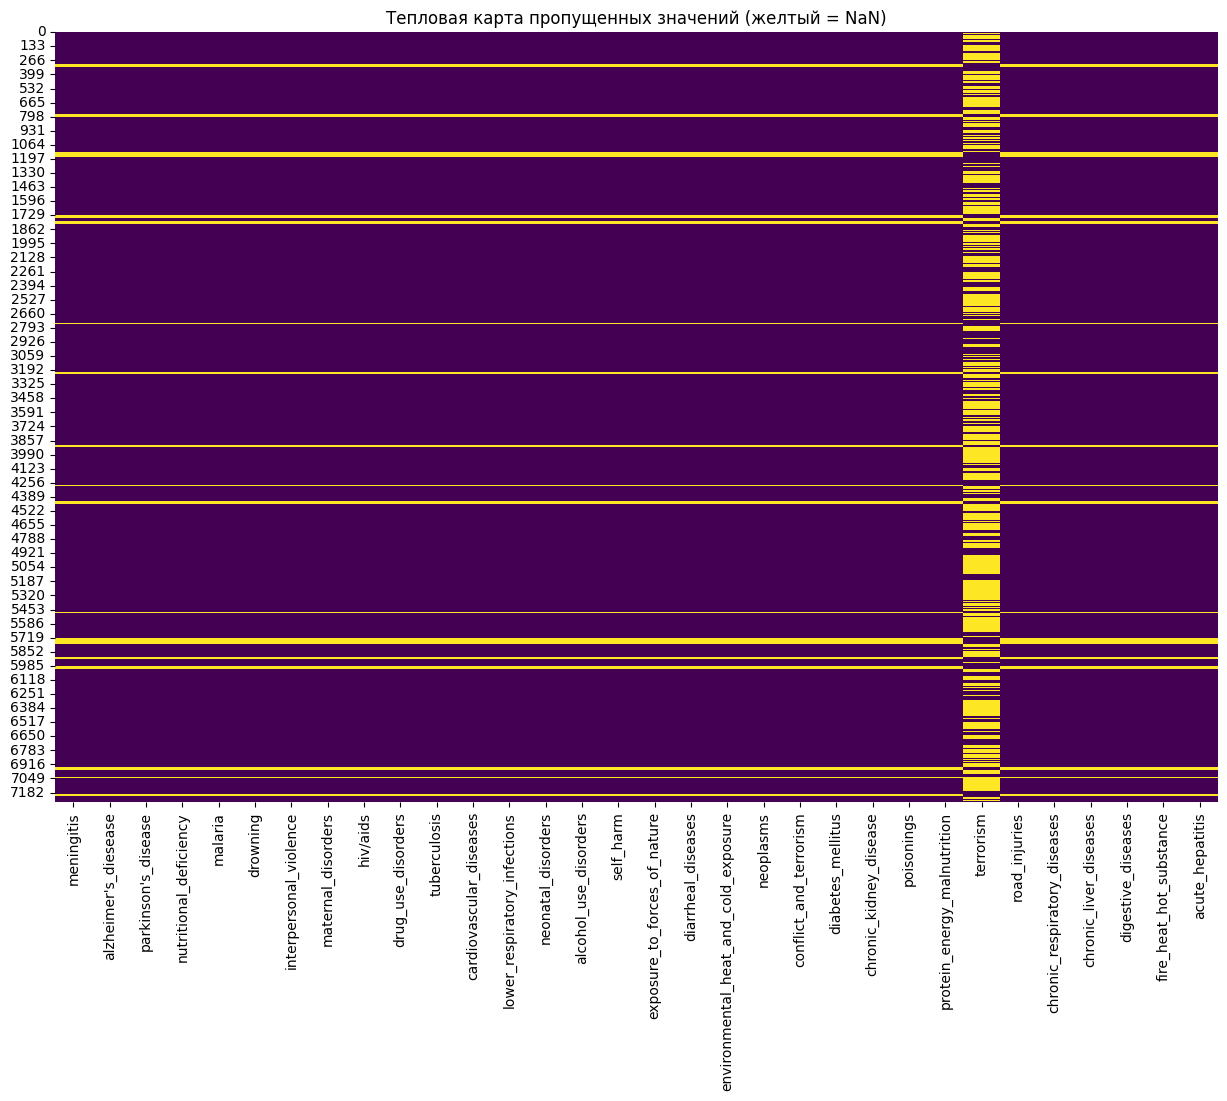

In [22]:
columns_with_nans = data.columns[data.isnull().any()].tolist()

if 'code' in columns_with_nans:
    columns_with_nans.remove('code')

plt.figure(figsize=(15, 10))
sns.heatmap(data[columns_with_nans].isnull(),
            cbar=False,
            cmap='viridis')
plt.title('Тепловая карта пропущенных значений (желтый = NaN)')
plt.show()

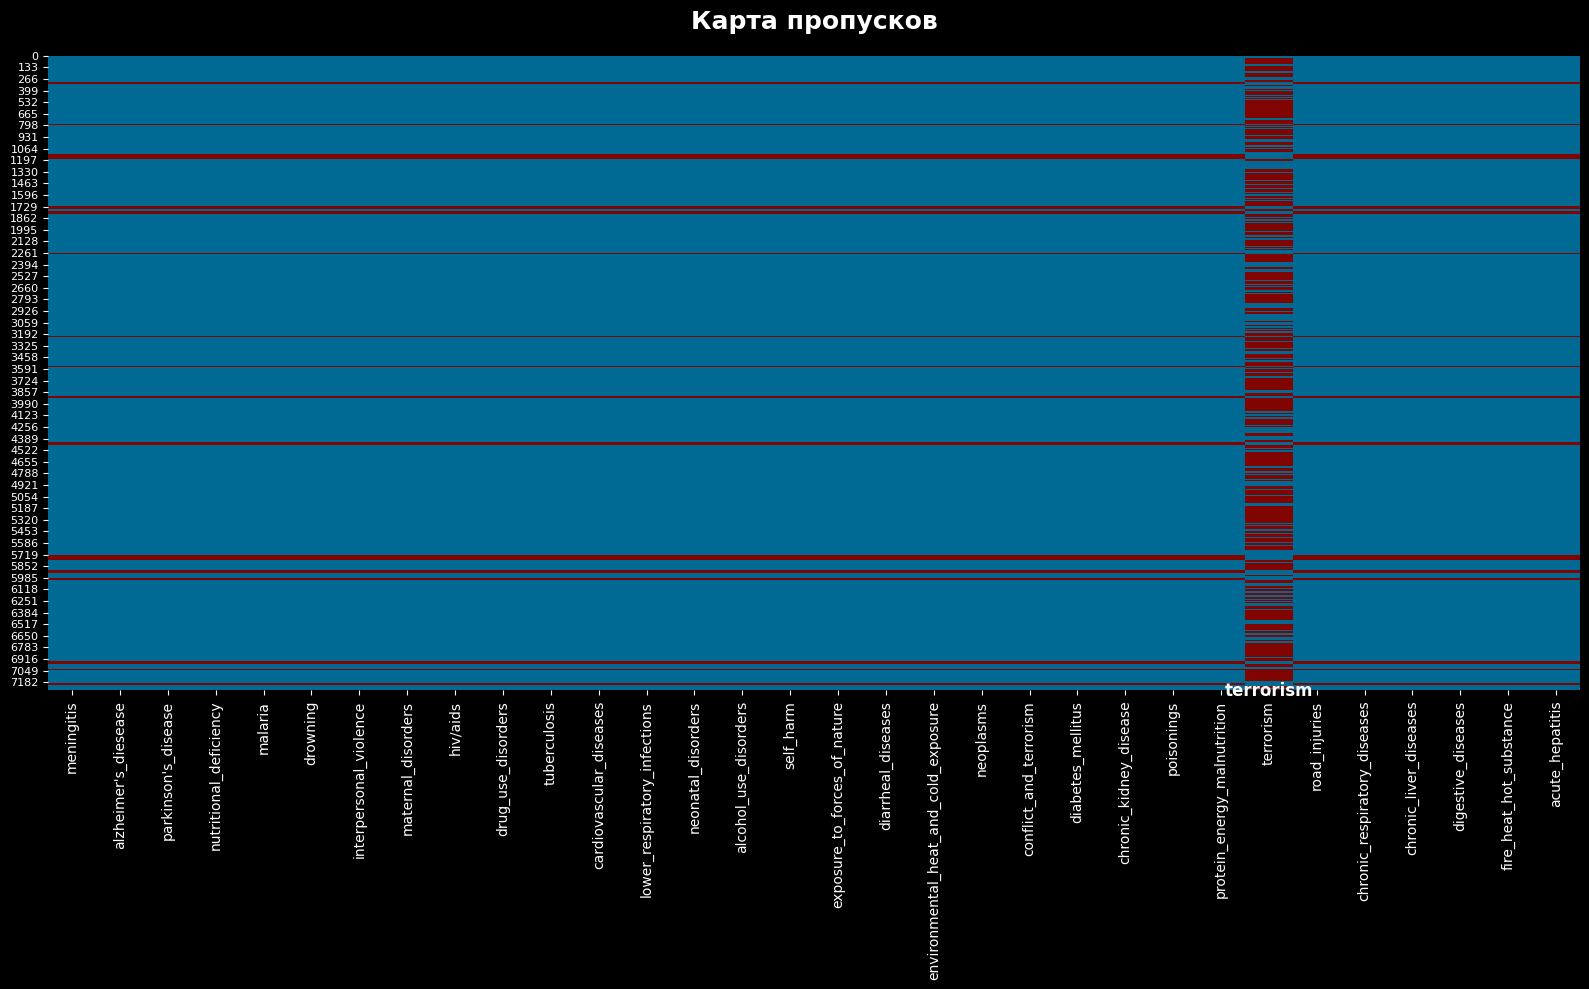

In [26]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Work Sans', 'DejaVu Sans']

COLORS = {
    'primary': '#006994',
    'accent': '#800400',
    'text': '#FFFFFF',
    'grid': '#2A2A4A'
}

columns_with_nans = data.columns[data.isnull().any()].tolist()
if 'code' in columns_with_nans:
    columns_with_nans.remove('code')

plt.figure(figsize=(16, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

sns.heatmap(
    data[columns_with_nans].isnull(),
    cbar=False,
    cmap=[COLORS['primary'], COLORS['accent']],
    ax=ax
)

ax.set_title('Карта пропусков',
             color=COLORS['text'],
             fontsize=18,
             fontweight='bold',
             pad=20)

if 'terrorism' in columns_with_nans:
    terrorism_idx = columns_with_nans.index('terrorism')
    plt.text(terrorism_idx + 0.5, len(data) + 50, 'terrorism',
             color=COLORS['text'],
             ha='center',
             fontsize=12,
             fontweight='bold')

ax.tick_params(axis='x', colors=COLORS['text'], rotation=90)
ax.tick_params(axis='y', colors=COLORS['text'], labelsize=8)

plt.tight_layout()
plt.show()

In [23]:
cause_columns = data.columns.drop(['country', 'code', 'year'])

rows_with_all_nan = data[data[cause_columns].isnull().all(axis=1)]

print(rows_with_all_nan['country'].unique())
print(f"Размер сомнительной части датасета со всеми пропусками: {rows_with_all_nan.shape}")

df_cleaned = data.dropna(subset=cause_columns, how='all')

['World (excluding China)']
Размер сомнительной части датасета со всеми пропусками: (10, 35)


Тогда эти строки можно удалить, т.к. это какая-то сущность, которая была создана для каких-то целей, нам непонятных. Мы вроде бы не хотим сравнивать весь мир с Китаем, так что можем избавиться от этих столбцов.

### Визуализации

Создадим второй датасет, который будет удобен для работы с визуализицями.

In [27]:
print(f"Размер датасета после удаления сомнительных строк: {data.shape}")

df_vis = pd.melt(
    df_cleaned,
    id_vars=['country', 'code', 'year'],
    value_vars=cause_columns,
    var_name='cause',
    value_name='deaths'
)
df_vis

Размер датасета после удаления сомнительных строк: (7273, 35)


country code  year            cause  deaths
0       Afghanistan  AFG  2007       meningitis  2933.0
1       Afghanistan  AFG  2008       meningitis  2731.0
2       Afghanistan  AFG  2009       meningitis  2460.0
3       Afghanistan  AFG  2011       meningitis  2327.0
4       Afghanistan  AFG  2012       meningitis  2254.0
...             ...  ...   ...              ...     ...
232411     Zimbabwe  ZWE  2015  acute_hepatitis   146.0
232412     Zimbabwe  ZWE  2016  acute_hepatitis   146.0
232413     Zimbabwe  ZWE  2017  acute_hepatitis   144.0
232414     Zimbabwe  ZWE  2018  acute_hepatitis   139.0
232415     Zimbabwe  ZWE  2019  acute_hepatitis   136.0

[232416 rows x 5 columns]

In [28]:
top_5_causes = df_vis.groupby('cause')['deaths'].sum().nlargest(5).reset_index()
display(top_5_causes.style.format({'deaths': '{:,.0f}'}))

Вполне ожидаемый, хоть и пугающий, результат в топе смертельности за весь датасет:
1) Сердечно-сосудистые заболевания
2) Опухоли(включая рак)
3) Хронические респираторные заболевания
4) Инфекции нижних дыхательных путей
5) Заболевания новорожденных. Этот признак присваевается, если младенец умер в первые 28 дней жизни

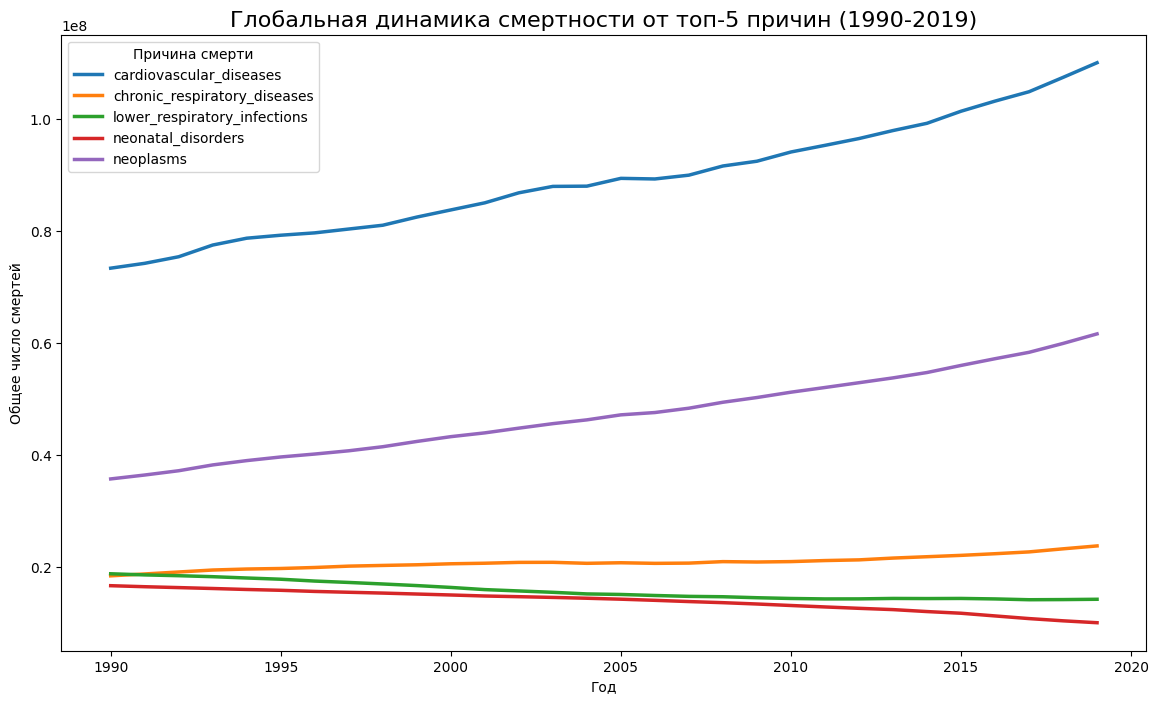

In [30]:
global_trends1 = df_vis.groupby(['year', 'cause'])['deaths'].sum().reset_index()

causes_to_plot = top_5_causes['cause'].tolist()

trends_subset = global_trends1[global_trends1['cause'].isin(causes_to_plot)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=trends_subset, x='year', y='deaths', hue='cause', lw=2.5)

plt.title('Глобальная динамика смертности от топ-5 причин (1990-2019)', fontsize=16)
plt.ylabel('Общее число смертей')
plt.xlabel('Год')
plt.legend(title='Причина смерти')
plt.show()

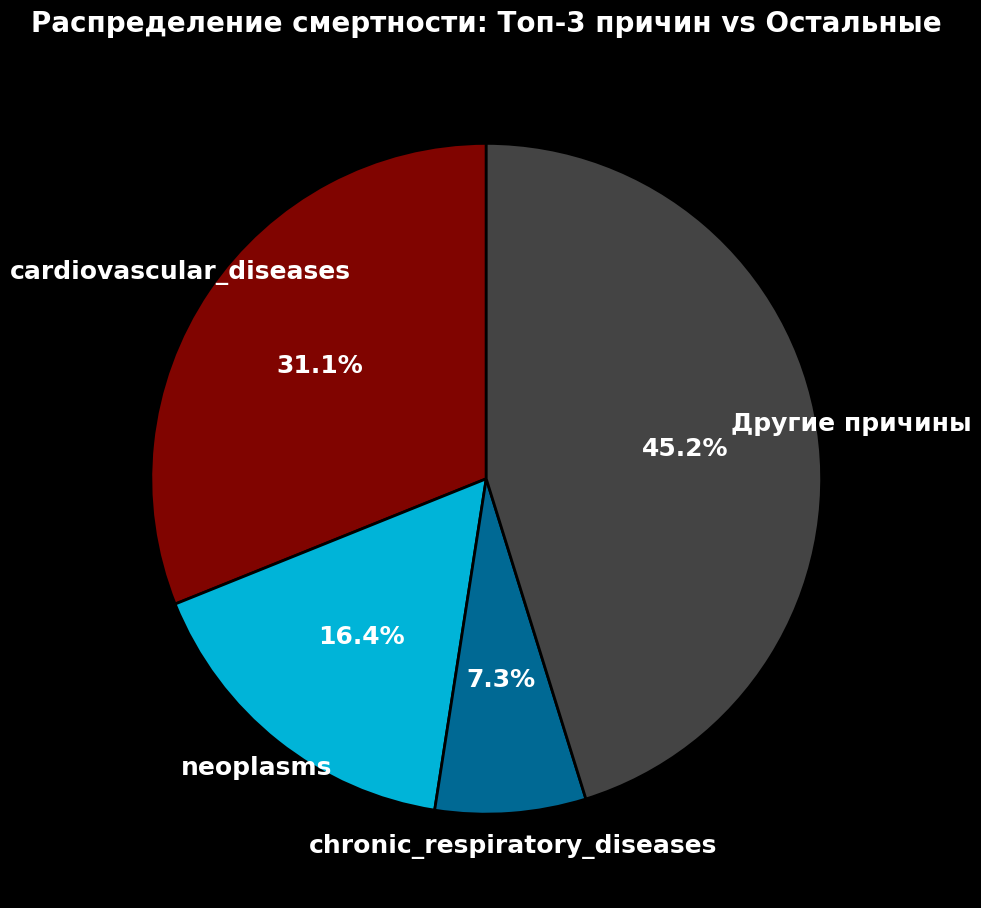

In [93]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Work Sans', 'DejaVu Sans']

COLORS = {
    'primary': '#006994',
    'accent': '#800400',
    'text': '#FFFFFF',
    'other': '#444444'
}

# Получаем топ-3 причины
top_causes = top_5_causes.head(3)['cause'].tolist()
top1, top2, top3 = top_causes

# Группируем данные по причинам смерти
total_deaths_by_cause = df_vis.groupby('cause')['deaths'].sum().reset_index()

# Получаем данные для топ-3 причин
top1_val = total_deaths_by_cause.loc[total_deaths_by_cause['cause'] == top1, 'deaths'].values[0]
top2_val = total_deaths_by_cause.loc[total_deaths_by_cause['cause'] == top2, 'deaths'].values[0]
top3_val = total_deaths_by_cause.loc[total_deaths_by_cause['cause'] == top3, 'deaths'].values[0]

# Вычисляем "Другие причины"
other_val = total_deaths_by_cause[
    ~total_deaths_by_cause['cause'].isin([top1, top2, top3])
]['deaths'].sum()

# Создаем упорядоченные данные
all_data = pd.DataFrame({
    'cause': [top1, top2, top3, 'Другие причины'],
    'deaths': [top1_val, top2_val, top3_val, other_val]
})

fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
ax.set_facecolor('black')

# Цвета в правильном порядке: top1 (красный), top2 (светло-синий), top3 (темно-синий), другие
colors = [COLORS['accent'], '#00B4D8', COLORS['primary'], COLORS['other']]

# Создаем круговую диаграмму
wedges, texts, autotexts = ax.pie(
    all_data['deaths'],
    labels=all_data['cause'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)

# Настраиваем подписи
for text, autotext in zip(texts, autotexts):
    text.set_color(COLORS['text'])
    text.set_fontsize(18)
    text.set_fontweight('bold')
    text.set_horizontalalignment('center')
    autotext.set_color(COLORS['text'])
    autotext.set_fontsize(18)
    autotext.set_fontweight('bold')

ax.set_title('Распределение смертности: Топ-3 причин vs Остальные',
             color=COLORS['text'],
             fontsize=20,
             fontweight='bold',
             pad=20)

plt.tight_layout()
plt.show()

In [94]:
top_causes = top_5_causes.head(3)['cause'].tolist()
total_deaths_by_cause = df_vis.groupby('cause')['deaths'].sum()

print("Количество смертей по топ-3 причинам:")
for cause in top_causes:
    deaths = total_deaths_by_cause.get(cause, 0)
    print(f"{cause}: {deaths:,.0f}")

total_deaths = df_vis['deaths'].sum()
print(f"\nСуммарное количество смертей: {total_deaths:,.0f}")

Количество смертей по топ-3 причинам:
cardiovascular_diseases: 2,674,494,456
neoplasms: 1,414,869,873
chronic_respiratory_diseases: 624,518,660

Суммарное количество смертей: 8,601,548,690


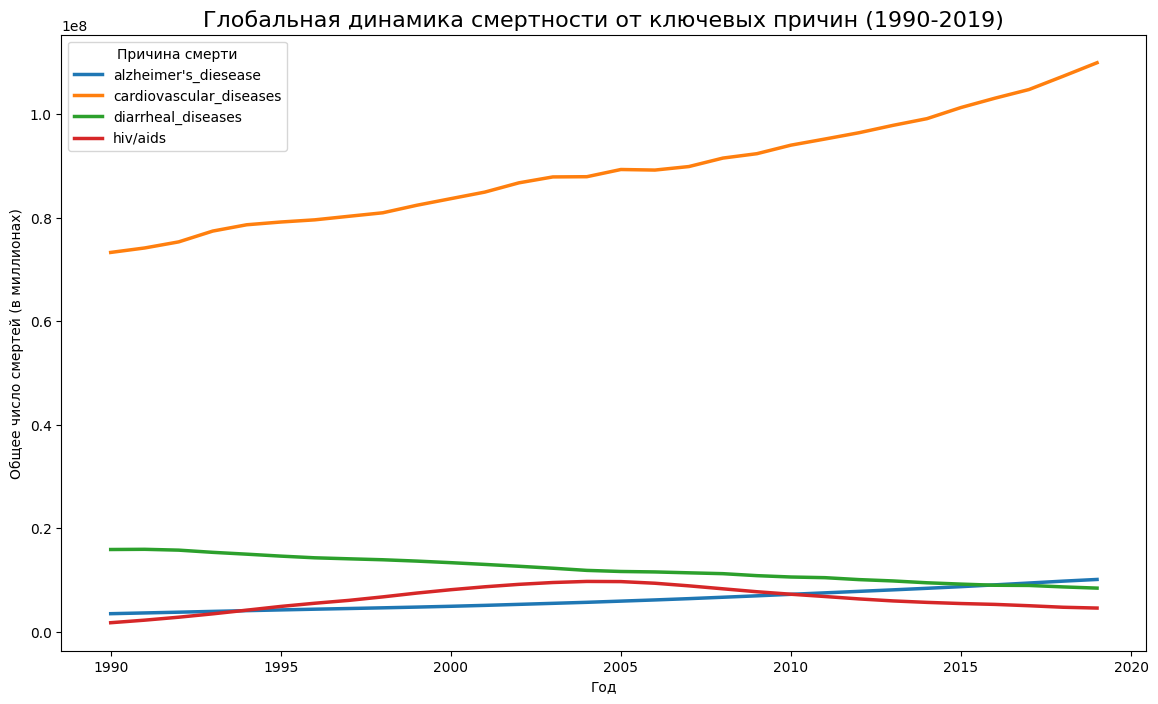

In [41]:
# рассмотрим еще некоторые интересующие признаки
global_trends = df_vis.groupby(['year', 'cause'])['deaths'].sum().reset_index()

causes_to_plot = [
    'cardiovascular_diseases',        # сердечно-сосудистые заболевания
    'hiv/aids',                       # глобальные эпидемии
    'diarrheal_diseases',             # индикатор антисанитарии
    "alzheimer's_diesease"            # альцгеймер
]

trends_subset = global_trends[global_trends['cause'].isin(causes_to_plot)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=trends_subset, x='year', y='deaths', hue='cause', lw=2.5)

plt.title('Глобальная динамика смертности от ключевых причин (1990-2019)', fontsize=16)
plt.ylabel('Общее число смертей (в миллионах)')
plt.xlabel('Год')
plt.legend(title='Причина смерти')
plt.show()

Видим спадающий тренд смертей от антисанитарии, что логично, т.к. на протяжении лет качество жизни улучшалось.

Но видим растущие тренды от других причин смерти, например от сердечно-сосудитсых заболеваний и болезни альцейгера, для чего тоже есть свои причины. Для ССЗ изменился образ жизни и теперь он более "сидячий", а альцгеймер это возрастное заболевание, и так как люди начинают жить дольше, то и людей с этой болезнью становится больше.

Такой анализ надо провести для интересующих нас стран и болезней.

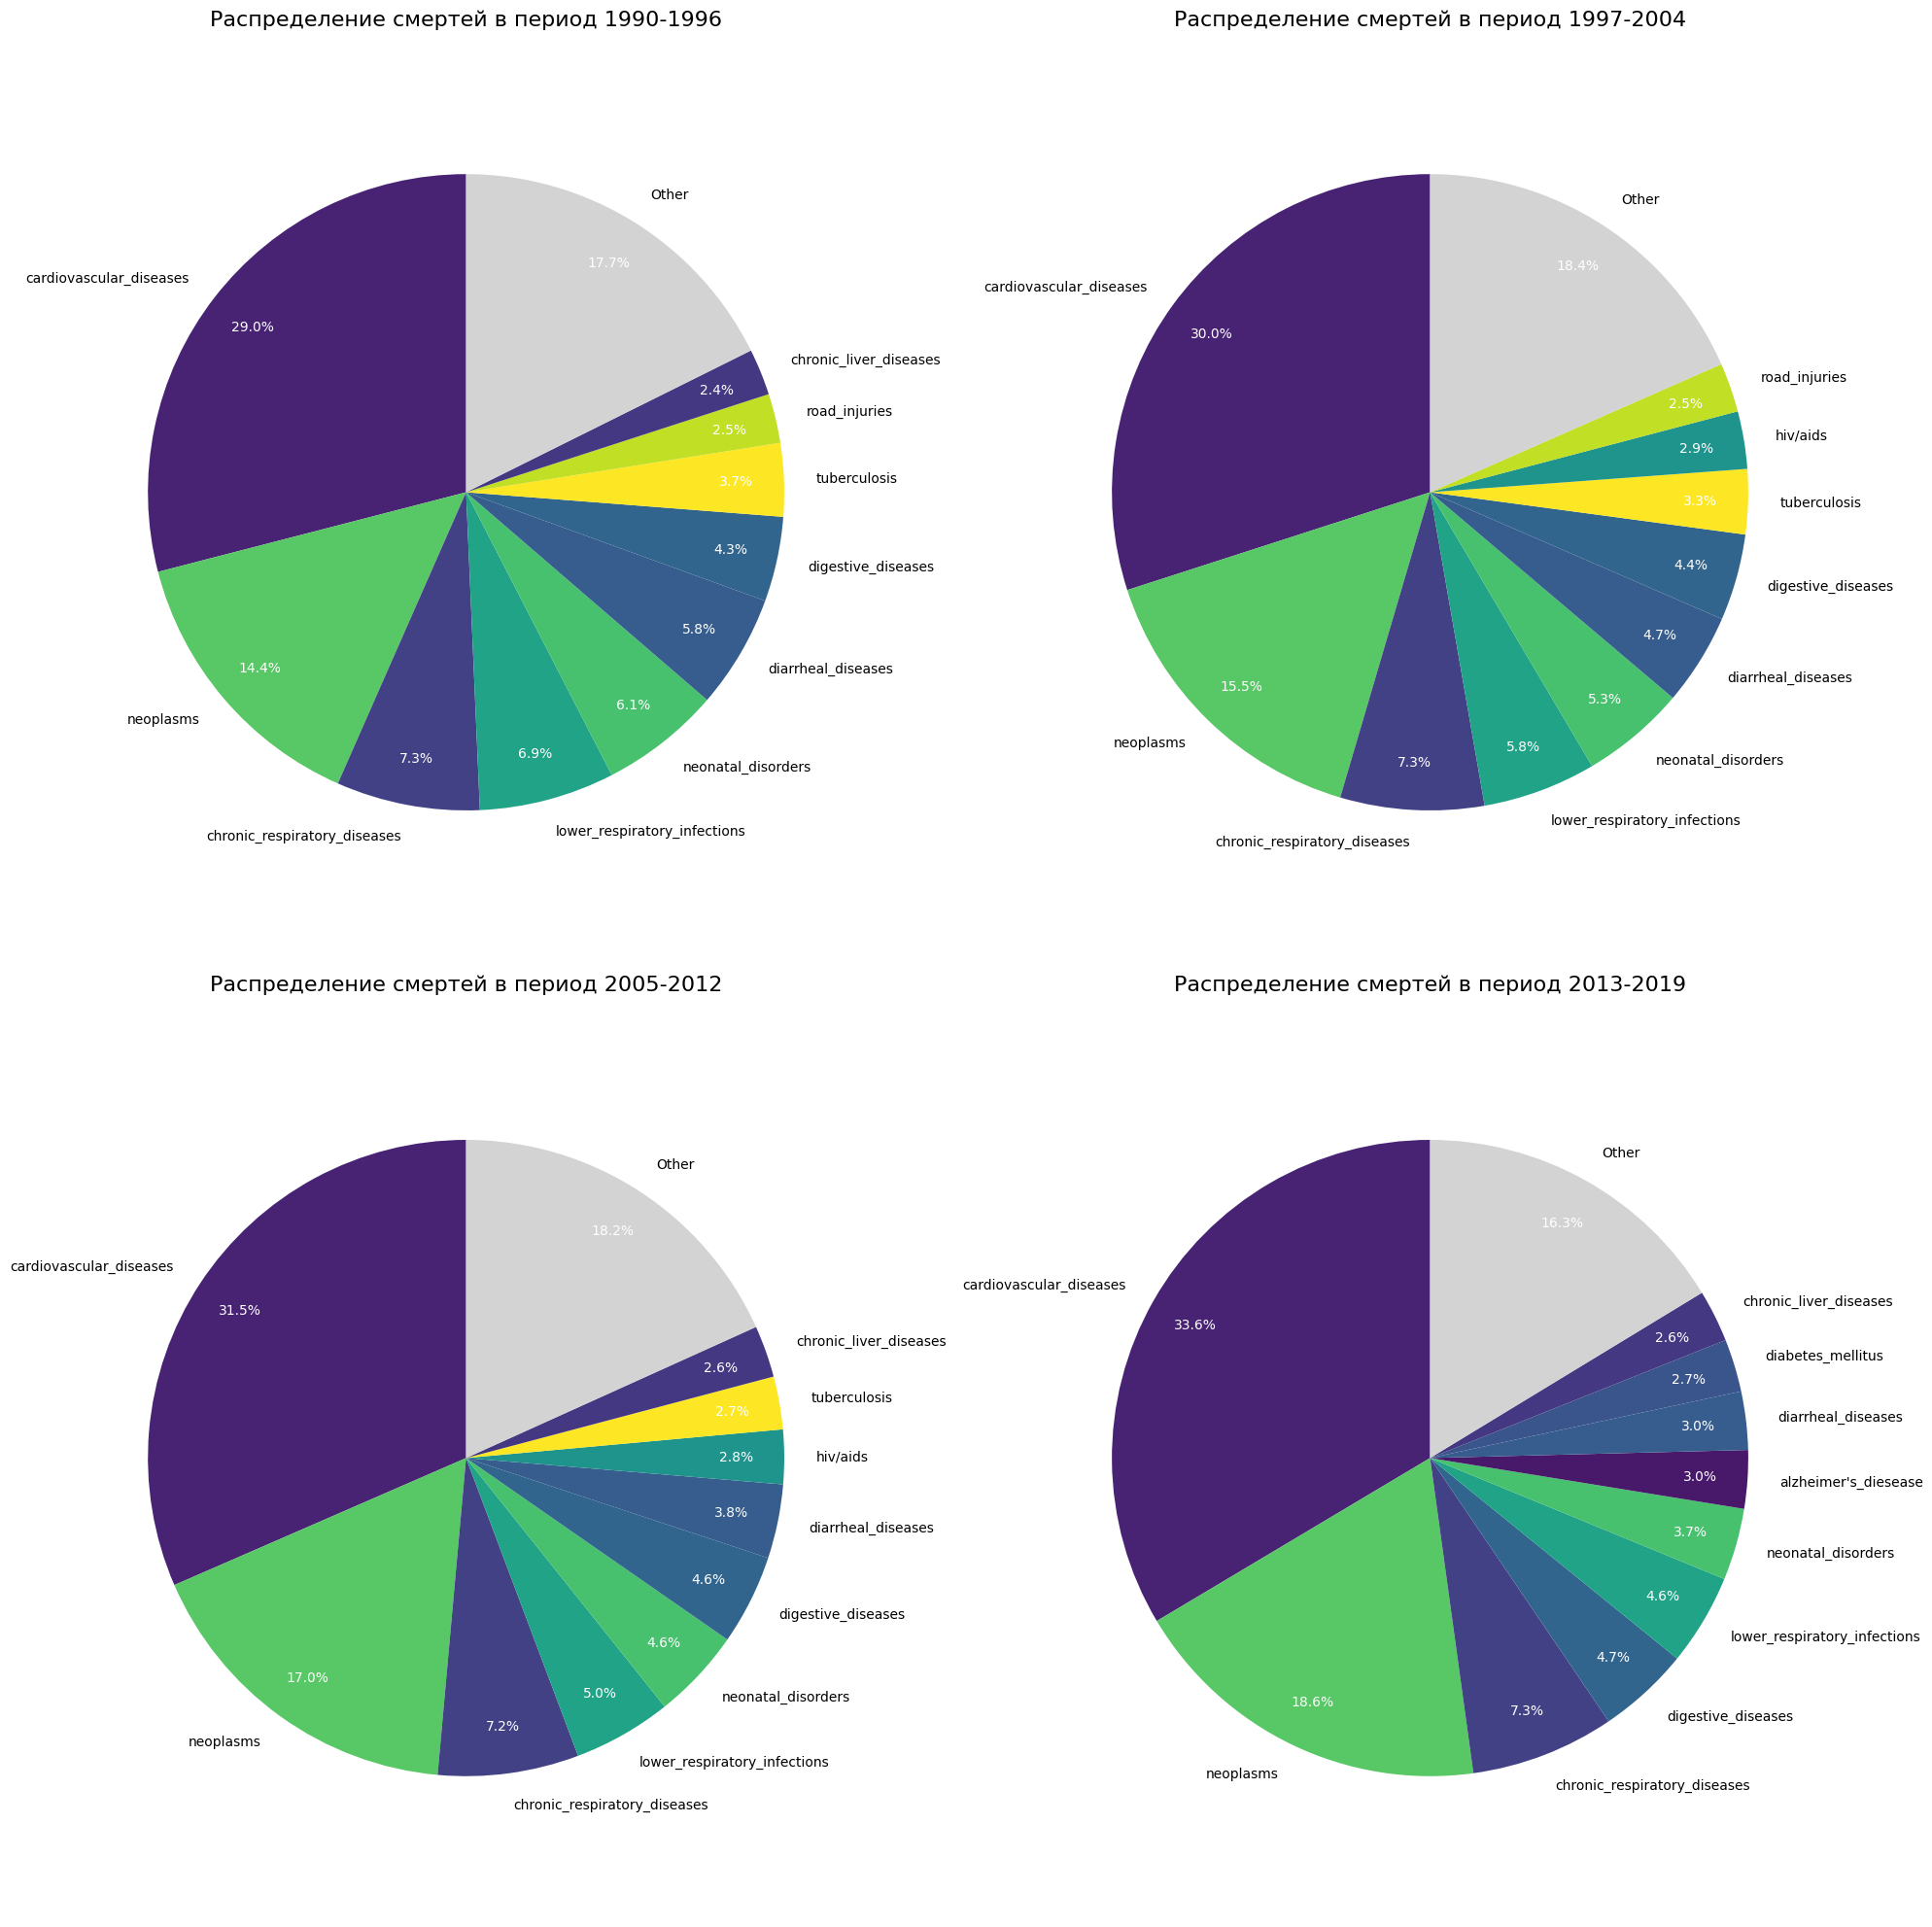

In [42]:
time_periods = {
    '1990-1996': (1990, 1996),
    '1997-2004': (1997, 2004),
    '2005-2012': (2005, 2012),
    '2013-2019': (2013, 2019)
}

all_unique_causes = sorted(df_vis['cause'].unique().tolist())

colors_list = plt.cm.viridis(np.linspace(0, 1, len(all_unique_causes)))
cause_colors = dict(zip(all_unique_causes, colors_list))

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()

for i, (period_name, (start_year, end_year)) in enumerate(time_periods.items()):
    period_data = df_vis[(df_vis['year'] >= start_year) & (df_vis['year'] <= end_year)]

    cause_distribution = period_data.groupby('cause')['deaths'].sum().sort_values(ascending=False)

    top_n = 10

    current_pie_labels = []
    current_pie_values = []
    current_pie_colors = []

    other_deaths = 0
    if len(cause_distribution) > top_n:
        current_pie_labels = cause_distribution.index[:top_n].tolist()
        current_pie_values = cause_distribution.values[:top_n].tolist()
        other_deaths = cause_distribution.iloc[top_n:].sum()
        if other_deaths > 0:
            current_pie_labels.append('Other')
            current_pie_values.append(other_deaths)
    else:
        current_pie_labels = cause_distribution.index.tolist()
        current_pie_values = cause_distribution.values.tolist()

    for label in current_pie_labels:
        if label == 'Other':
            current_pie_colors.append('lightgray')
        else:
            current_pie_colors.append(cause_colors.get(label, 'black'))

    wedges, texts, autotexts = axes[i].pie(current_pie_values,
                                           labels=current_pie_labels,
                                           autopct='%1.1f%%',
                                           startangle=90,
                                           pctdistance=0.85,
                                           colors=current_pie_colors)
    axes[i].set_title(f'Распределение смертей в период {period_name}', fontsize=16)
    axes[i].axis('equal')

    for autotext in autotexts:
        autotext.set_color('white')

plt.tight_layout()
plt.show()

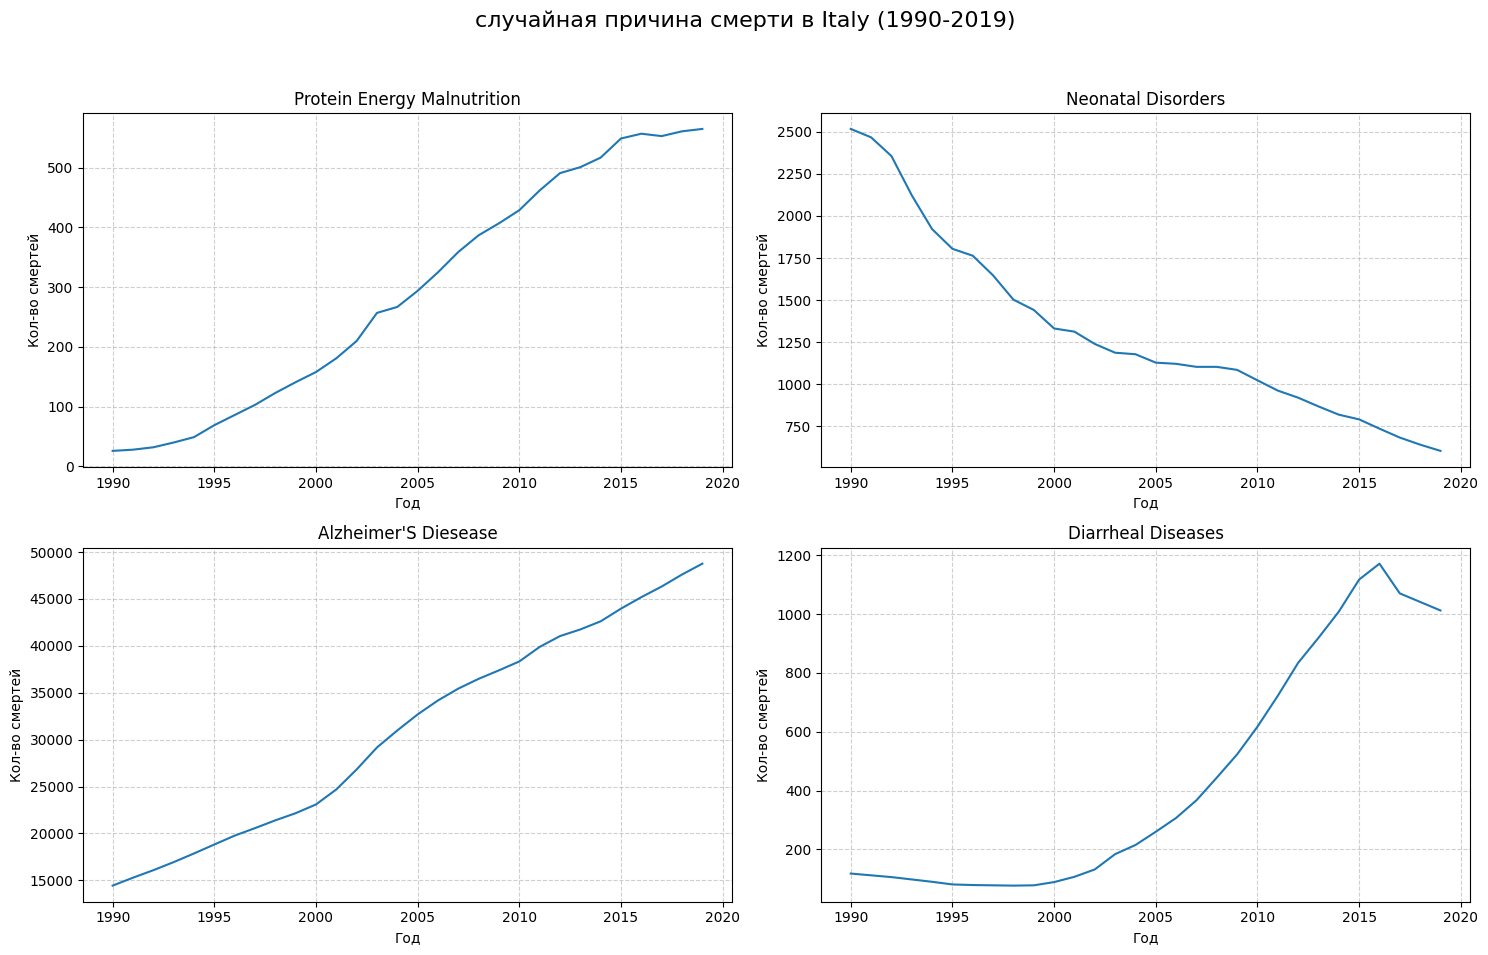

In [91]:
countries = data['country'].unique()

random_country = np.random.choice(countries)

country_data = data[data['country'] == random_country].copy()
cause_of_death_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64'] and col not in ['year']]
country_data[cause_of_death_cols] = country_data[cause_of_death_cols].fillna(0)

if len(cause_of_death_cols) >= 4:
    random_causes = np.random.choice(cause_of_death_cols, 4, replace=False)
else:
    print("Представлено недостаточно даных")
    random_causes = cause_of_death_cols

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

fig.suptitle(f'случайная причина смерти в {random_country} (1990-2019)', fontsize=16)

for i, cause in enumerate(random_causes):
    sns.lineplot(x='year', y=cause, data=country_data, ax=axes[i])
    axes[i].set_title(cause.replace('_', ' ').title())
    axes[i].set_xlabel('Год')
    axes[i].set_ylabel('Кол-во смертей')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [44]:
# случайно нашел строчки с сомнительной страной
df_cleaned[df_cleaned["country"] == "World Bank Low Income"].head()

country code  year  meningitis  alzheimer's_diesease  \
7075  World Bank Low Income  NaN  1990    114623.0               15071.0   
7076  World Bank Low Income  NaN  1991    114812.0               15569.0   
7077  World Bank Low Income  NaN  1992    116674.0               16112.0   
7078  World Bank Low Income  NaN  1993    117168.0               16660.0   
7079  World Bank Low Income  NaN  1994    115897.0               17208.0   

      parkinson's_disease  nutritional_deficiency   malaria  drowning  \
7075               4534.0                188448.0  369731.0   26664.0   
7076               4647.0                187392.0  376937.0   26139.0   
7077               4772.0                188294.0  377923.0   26087.0   
7078               4898.0                188121.0  385475.0   25982.0   
7079               5019.0                186830.0  387320.0   25719.0   

      interpersonal_violence  ...  chronic_kidney_disease  poisonings  \
7075                 21065.0  ...                 43645.0     13212.0   
7076                 22476.0  ...                 44433.0     13201.0   
7077                 27175.0  ...                 45354.0     13280.0   
7078                 27492.0  ...                 46178.0     13244.0   
7079                 25651.0  ...                 46982.0     13204.0   

      protein_energy_malnutrition  terrorism  road_injuries  \
7075                     181654.0        NaN        82028.0   
7076                     180685.0        NaN        83597.0   
7077                     181641.0        NaN        85405.0   
7078                     181537.0        NaN        86823.0   
7079                     180335.0        NaN        88117.0   

      chronic_respiratory_diseases  chronic_liver_diseases  \
7075                      117865.0                 79174.0   
7076                      119824.0                 80441.0   
7077                      121826.0                 81756.0   
7078                      123933.0                 82829.0   
7079                      125868.0                 83968.0   

      digestive_diseases  fire_heat_hot_substance  acute_hepatitis  
7075            132353.0                  12479.0          14813.0  
7076            134432.0                  12525.0          14940.0  
7077            136688.0                  12641.0          15248.0  
7078            138540.0                  12643.0          15583.0  
7079            140489.0                  12644.0          15895.0  

[5 rows x 35 columns]

In [95]:
df_cleaned = df_cleaned[df_cleaned["country"] != "World Bank Low Income"]
df_cleaned.shape

(7233, 35)

### Базовые модели

На этом этапе важно установить, что четкого таргета в датасета нет, поэтому мы ставим задачу - грамотно предсказывать смертность в том или ином виде в будущем, опираясь на статистику прошлого, выделим 4 кейса:

1) смерти по 1 причине в 1 стране
2) смерти по всем причинам в 1 стране
3) смерти во всех странах по 1 причине
4) смерти во всем мире по всем причинам

В нашем случае базовую модель от продвинутой можно отделить по простому критерию: предсказание одной величины в будущем зависит ТОЛЬКО от ее же значений в прошлом.

Поэтому среди базовых моделей представим шикарный линрег, млп с синусами и косинусами и т.д.


Важное замечание!

Будем считать, что наше предсказание прошло бейзлайн, если оно предсказывает значение лучше чем линрег по трейну. С выбором функции ошибки пока повременим

#### линрег

In [96]:
class LinearTrend:
    def __init__(self, data):
        self.data = data.copy()

    def fit_and_predict(self, country, cause, start_year, end_year):
        df = self.data[self.data['country'] == country][['year', cause]].dropna(subset=[cause])
        df = df[(df['year'] >= start_year) & (df['year'] <= end_year + 1)]

        if len(df) < 2:
            raise ValueError("Недостаточно данных для построения тренда")

        # 2. Обучение на [start_year, end_year]
        train = df[df['year'] <= end_year]
        X_train = train['year'].values.reshape(-1, 1)
        y_train = train[cause].values

        self.model = LinearRegression().fit(X_train, y_train)
        self.df_plot = df
        self.cause = cause
        self.country = country
        self.start_year = start_year
        self.end_year = end_year
        self.next_year = end_year + 1

        # Прогноз
        self.predicted = self.model.predict([[self.next_year]])[0]

        # Фактическое (если есть)
        actual_row = df[df['year'] == self.next_year]
        self.actual = actual_row[cause].values[0] if len(actual_row) == 1 else None
        self.error = abs(self.predicted - self.actual) if self.actual is not None else None

        return self

    def plot(self):
        if not hasattr(self, 'model'):
            raise ValueError("Сначала вызовите .fit_and_predict()")

        plt.figure(figsize=(9, 5))
        plt.scatter(self.df_plot['year'], self.df_plot[self.cause],
                   color='steelblue', s=100, zorder=5, label='Actual')

        x_line = self.df_plot['year'].values.reshape(-1, 1)
        plt.plot(self.df_plot['year'], self.model.predict(x_line),
                color='red', linewidth=2, label='Trend')

        if self.actual is not None:
            plt.scatter(self.next_year, self.actual, color='green', s=150,
                       edgecolor='black', linewidth=1.5, zorder=10, label='Real')
            plt.scatter(self.next_year, self.predicted, color='red', s=150,
                       edgecolor='white', linewidth=2, zorder=10)
            plt.title(f'{self.country}: {self.cause.replace("_", " ")}\n'
                      f'{self.start_year}-{self.end_year} -> {self.next_year}\n'
                      f'Pred: {self.predicted:.0f}, Real: {self.actual:.0f}, Error: {self.error:.0f}')
        else:
            plt.scatter(self.next_year, self.predicted, color='red', s=150,
                       edgecolor='white', linewidth=2, zorder=10)
            plt.title(f'{self.country}: {self.cause.replace("_", " ")}\n'
                      f'{self.start_year}–{self.end_year} -> {self.next_year} prediction: {self.predicted:.0f}')

        plt.grid(alpha=0.3)
        plt.xlabel('Year')
        plt.ylabel('Deaths')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def get_prediction(self):
        """Вернуть словарь с результатом"""
        return {
            'country': self.country,
            'cause': self.cause,
            'next_year': self.next_year,
            'predicted': round(self.predicted),
            'actual': round(self.actual) if self.actual is not None else None,
            'error': round(self.error) if self.error is not None else None
        }

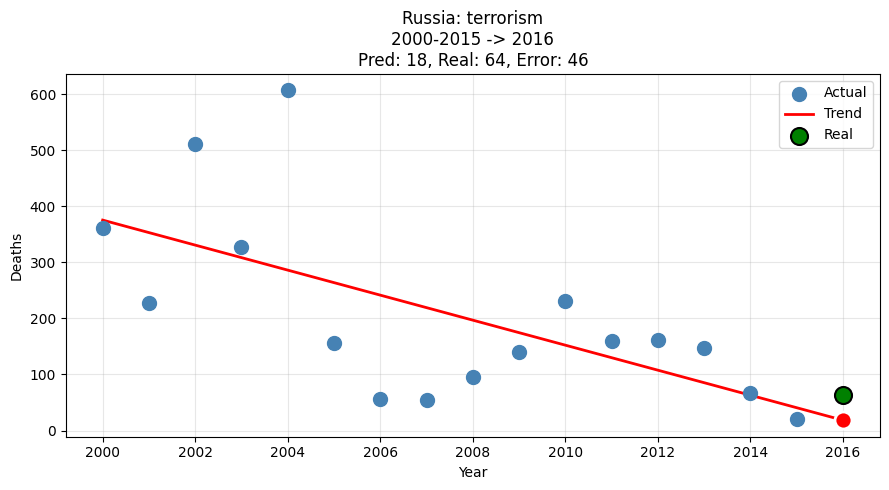

{'country': 'Russia', 'cause': 'terrorism', 'next_year': 2016, 'predicted': 18, 'actual': 64, 'error': 46}


In [97]:
trend = LinearTrend(data)

# просто строим график
trend.fit_and_predict("Russia", "terrorism", 2000, 2015).plot()

# получаем результат
result = trend.fit_and_predict("Russia", "terrorism", 2000, 2015).get_prediction()
print(result)

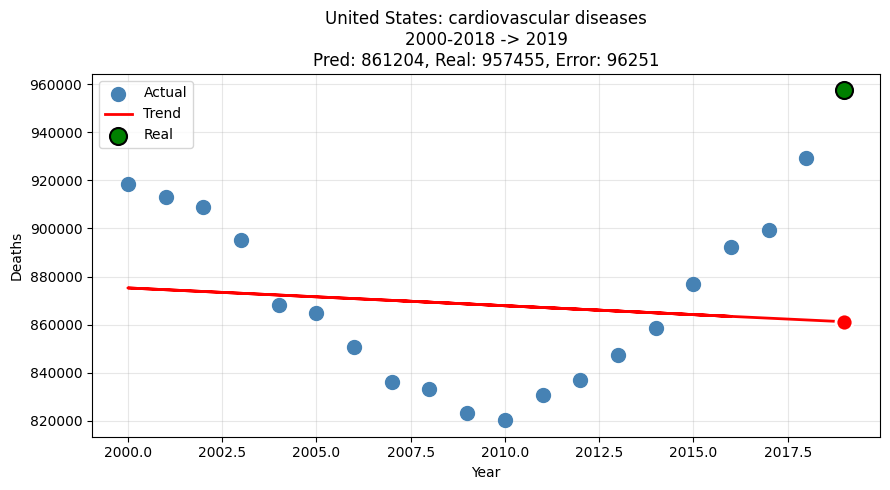

{'country': 'United States', 'cause': 'cardiovascular_diseases', 'next_year': 2019, 'predicted': 861204, 'actual': 957455, 'error': 96251}


In [98]:
trend.fit_and_predict("United States", "cardiovascular_diseases", 2000, 2018).plot()
print(trend.get_prediction())

сделали класс для самого простого способа предсказания (если отбросить предсказание модой/медианой), он иногда точный, иногда неточный, зато базовая модель готова

#### линрег 2.0

In [99]:
import os

# Создаём папку, если её нет
os.makedirs("linreg_vis", exist_ok=True)

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

class LinearTrend:
    def __init__(self, data, country, target, train_start, train_end, test_end):
        """
        Параметры:
            data         - исходный датафрейм
            country      - страна
            target       - столбец (причина смерти)
            train_start  - год начала обучения (включительно)
            train_end    - год конца обучения (включительно)
            test_end     - последний год прогноза (включительно)
                         - тест начинается с train_end + 1
        """
        self.data = data
        self.country = country
        self.target = target
        self.train_start = train_start
        self.train_end = train_end
        self.test_end = test_end

        train_mask = (
            (data['country'] == country) &
            (data['year'] >= train_start) &
            (data['year'] <= train_end)
        )
        train_df = data.loc[train_mask, ['year', target]].dropna()

        if train_df.empty or len(train_df) < 2:
            raise ValueError(f"Нет данных для обучения: {country}, {target}, {train_start}–{train_end}")

        self.X_train = train_df['year'].values.reshape(-1, 1)
        self.y_train = train_df[target].values

        test_mask = (
            (data['country'] == country) &
            (data['year'] > train_end) &
            (data['year'] <= test_end)
        )
        self.test_df = data.loc[test_mask, ['year', target]].dropna()

        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)

        self.forecast_years = list(range(train_end + 1, test_end + 1))

    def predict_and_plot(self, save=False):
        """Рисует график и выводит прогноз — один в один как у вас было раньше"""
        forecast_years = np.array(self.forecast_years).reshape(-1, 1)
        pred = self.model.predict(forecast_years).astype(int)

        plt.figure(figsize=(12, 6))

        # Исторические точки (обучение)
        plt.plot(self.X_train, self.y_train, 'o', color='steelblue', markersize=8, label='Обучающие данные')

        # Реальные тестовые точки (если есть)
        if not self.test_df.empty:
            plt.plot(self.test_df['year'], self.test_df[self.target], 'o', color='orange', markersize=8, label='Реальные (тест)')

        # Линия тренда (по обучающим годам)
        years_line = np.array([self.train_start, self.train_end]).reshape(-1, 1)
        trend_line = self.model.predict(years_line)
        plt.plot([self.train_start, self.train_end], trend_line,
                 color='red', linewidth=2, linestyle='--')

        # Продолжение тренда на прогноз
        all_years = np.concatenate([self.X_train.flatten(), forecast_years.flatten()])
        extended_pred = self.model.predict(all_years.reshape(-1, 1))
        plt.plot(np.sort(all_years), extended_pred[np.argsort(all_years.flatten())],
                 color='red', linewidth=2, linestyle='--', label='Линейный тренд')

        # Точки прогноза
        plt.plot(forecast_years,
                 pred,
                 's',
                 color='green',
                 markersize=10,
                 label='Прогноз')

        plt.title(f'{self.target} — {self.country}', fontsize=14)
        plt.xlabel('Год')
        plt.ylabel('Количество смертей')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # СОХРАНЕНИЕ ИЛИ ПОКАЗ
        if save:
            filename = f"linreg_vis/{self.country}_{self.target}_train1990-{self.train_end}_pred{self.train_end+1}-{self.test_end}.png"
            plt.savefig(filename, dpi=200, bbox_inches='tight')
            plt.close()  # закрываем фигуру, чтобы не показывалась в ноутбуке
            print(f"Сохранено: {filename}")
        else:
            plt.show()

        """print(f"Прогноз {self.target} для {self.country} "
              f"(обучение: {self.train_start}-{self.train_end}, прогноз: {self.train_end+1}-{self.test_end}):")
        for year, value in zip(self.forecast_years, pred):
            real = self.test_df[self.test_df['year'] == year][self.target].values
            real_str = f" (реально: {int(real[0])})" if len(real) > 0 else ""
            print(f"  {year} год -> {value}{real_str}")"""

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Work Sans', 'DejaVu Sans']

COLORS = {
    'primary': '#006994',
    'accent': '#800400',
    'text': '#FFFFFF',
    'grid': '#2A2A4A',
    'train': '#006994',
    'test': '#FFA500',
    'trend': '#800400',
    'forecast': '#00FF00'
}

class LinearTrend:
    def __init__(self, data, country, target, train_start, train_end, test_end):
        """
        Параметры:
            data         - исходный датафрейм
            country      - страна
            target       - столбец (причина смерти)
            train_start  - год начала обучения (включительно)
            train_end    - год конца обучения (включительно)
            test_end     - последний год прогноза (включительно)
                         - тест начинается с train_end + 1
        """
        self.data = data
        self.country = country
        self.target = target
        self.train_start = train_start
        self.train_end = train_end
        self.test_end = test_end

        train_mask = (
            (data['country'] == country) &
            (data['year'] >= train_start) &
            (data['year'] <= train_end)
        )
        train_df = data.loc[train_mask, ['year', target]].dropna()

        if train_df.empty or len(train_df) < 2:
            raise ValueError(f"Нет данных для обучения: {country}, {target}, {train_start}–{train_end}")

        self.X_train = train_df['year'].values.reshape(-1, 1)
        self.y_train = train_df[target].values

        test_mask = (
            (data['country'] == country) &
            (data['year'] > train_end) &
            (data['year'] <= test_end)
        )
        self.test_df = data.loc[test_mask, ['year', target]].dropna()

        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)

        self.forecast_years = list(range(train_end + 1, test_end + 1))

    def predict_and_plot(self, save=False):
        """Рисует график в нашем стиле"""
        forecast_years = np.array(self.forecast_years).reshape(-1, 1)
        pred = self.model.predict(forecast_years).astype(int)

        fig, ax = plt.subplots(figsize=(12, 6), facecolor='black')
        ax.set_facecolor('black')

        # Исторические точки (обучение)
        ax.plot(self.X_train, self.y_train, 'o', color=COLORS['train'], markersize=8, label='Обучающие данные')

        # Реальные тестовые точки (если есть)
        if not self.test_df.empty:
            ax.plot(self.test_df['year'], self.test_df[self.target], 'o', color=COLORS['test'], markersize=8, label='Реальные (тест)')

        # Линия тренда (по обучающим годам)
        years_line = np.array([self.train_start, self.train_end]).reshape(-1, 1)
        trend_line = self.model.predict(years_line)
        ax.plot([self.train_start, self.train_end], trend_line,
                 color=COLORS['trend'], linewidth=2, linestyle='--')

        # Продолжение тренда на прогноз
        all_years = np.concatenate([self.X_train.flatten(), forecast_years.flatten()])
        extended_pred = self.model.predict(all_years.reshape(-1, 1))
        ax.plot(np.sort(all_years), extended_pred[np.argsort(all_years.flatten())],
                 color=COLORS['trend'], linewidth=2, linestyle='--', label='Линейный тренд')

        # Точки прогноза
        ax.plot(forecast_years,
                 pred,
                 's',
                 color=COLORS['forecast'],
                 markersize=10,
                 label='Прогноз')

        # Настройка оформления
        ax.set_title(f'{self.target} — {self.country}',
                     color=COLORS['text'],
                     fontsize=16,
                     fontweight='bold',
                     pad=20)
        ax.set_xlabel('Год', color=COLORS['text'], fontsize=12)
        ax.set_ylabel('Количество смертей', color=COLORS['text'], fontsize=12)

        ax.tick_params(axis='x', colors=COLORS['text'])
        ax.tick_params(axis='y', colors=COLORS['text'])

        ax.spines['bottom'].set_color(COLORS['text'])
        ax.spines['left'].set_color(COLORS['text'])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.grid(True, color=COLORS['grid'], alpha=0.3, linestyle='--')

        legend = ax.legend(facecolor='black', edgecolor=COLORS['text'], fontsize=10)
        for text in legend.get_texts():
            text.set_color(COLORS['text'])

        plt.tight_layout()

        if save:
            filename = f"linreg_vis/{self.country}_{self.target}_train1990-{self.train_end}_pred{self.train_end+1}-{self.test_end}.png"
            plt.savefig(filename, dpi=200, bbox_inches='tight', facecolor='black')
            plt.close()
            print(f"Сохранено: {filename}")
        else:
            plt.show()

In [ ]:
df_vis['cause'].unique()

array(['meningitis', "alzheimer's_diesease", "parkinson's_disease",
       'nutritional_deficiency', 'malaria', 'drowning',
       'interpersonal_violence', 'maternal_disorders', 'hiv/aids',
       'drug_use_disorders', 'tuberculosis', 'cardiovascular_diseases',
       'lower_respiratory_infections', 'neonatal_disorders',
       'alcohol_use_disorders', 'self_harm',
       'exposure_to_forces_of_nature', 'diarrheal_diseases',
       'environmental_heat_and_cold_exposure', 'neoplasms',
       'conflict_and_terrorism', 'diabetes_mellitus',
       'chronic_kidney_disease', 'poisonings',
       'protein_energy_malnutrition', 'terrorism', 'road_injuries',
       'chronic_respiratory_diseases', 'chronic_liver_diseases',
       'digestive_diseases', 'fire_heat_hot_substance', 'acute_hepatitis'],
      dtype=object)

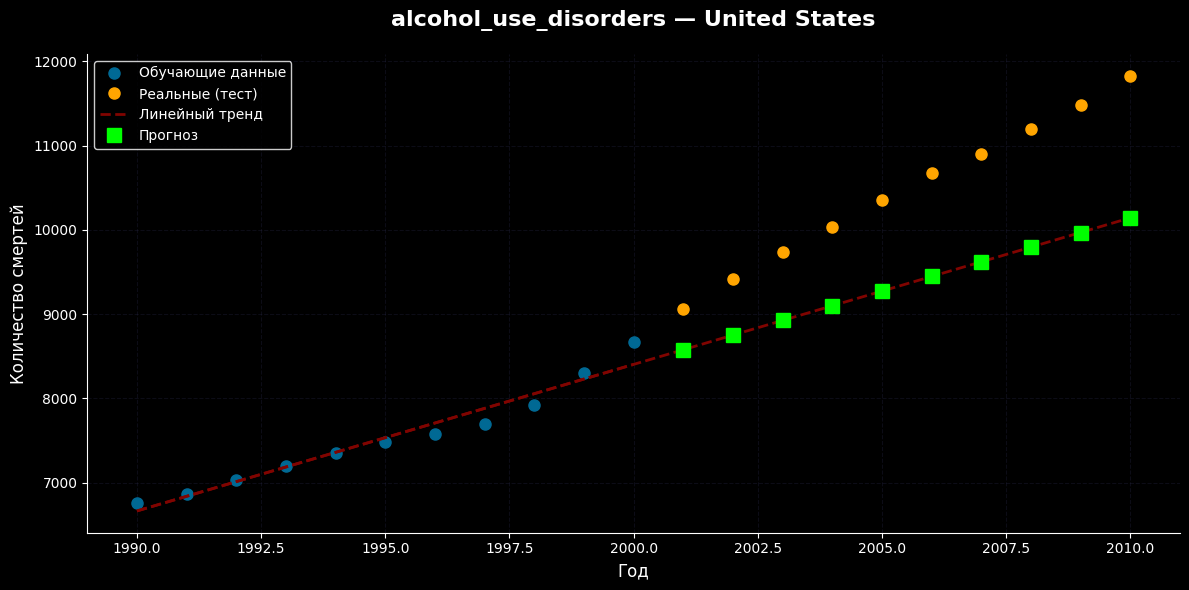

In [106]:
lt = LinearTrend(
    data=data,
    country="United States",
    target="alcohol_use_disorders",
    train_start=1990,
    train_end=2000,
    test_end=2010
)

lt.predict_and_plot()

In [107]:
# сохранение кадров для анимации

for last_year in range(1992, 2019):
    lt = LinearTrend(
    data=data,
    country="United States",
    target="alcohol_use_disorders",
    train_start=1990,
    train_end=last_year,
    test_end=2019
    )

    lt.predict_and_plot(save=True)

Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1992_pred1993-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1993_pred1994-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1994_pred1995-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1995_pred1996-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1996_pred1997-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1997_pred1998-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1998_pred1999-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-1999_pred2000-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-2000_pred2001-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-2001_pred2002-2019.png
Сохранено: linreg_vis/United States_alcohol_use_disorders_train1990-2002_pred2003-2019.png

In [ ]:
# очистим linreg_vis

In [109]:
# скачивание гифки анимации обучения линрега классом

import os
from PIL import Image
import numpy as np
import imageio.v2 as imageio
from google.colab import files

image_folder = '/content/linreg_vis'
gif_path = '/content/rolling_forecast.gif'

image_paths = sorted(
    [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')],
    key=lambda x: int(x.split('_train1990-')[1].split('_')[0])
)

print(f"Найдено изображений: {len(image_paths)}")

images = []
for path in image_paths:
    img = Image.open(path)

    if img.mode != 'RGB':
        img = img.convert('RGB')

    if not images:
        target_size = img.size
        print(f"Эталонный размер: {target_size}")
    else:
        if img.size != target_size:
            img = img.resize(target_size, Image.LANCZOS)

    img_array = np.array(img)
    images.append(img_array)

print(f"Все изображения приведены к размеру: {images[0].shape}")

imageio.mimsave(gif_path, images, fps=3, loop=0)  # 0.2 секунды на кадр

print(f"Гифка успешно создана: {gif_path}")
print(f"Кадров: {len(images)}")

files.download(gif_path)

Найдено изображений: 27
Эталонный размер: (2373, 1179)
Все изображения приведены к размеру: (1179, 2373, 3)
Гифка успешно создана: /content/rolling_forecast.gif
Кадров: 27


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ЕСЛИ ВЫ ЭТО ВИДИТЕ ОТКРОЙТЕ И ПОСМОТРИТЕ ГИФКУ

#### МСП на скользящих окнах

Оказывается, мcп нельзя. Очень грустно было удалять полурабочий класс с визуализацией обучения

#### SVM на временных батчах

#### легкий катбустик по терроризму

In [ ]:
TARGET = "terrorism"

df_model = data.dropna(subset=[TARGET]).copy()

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

In [ ]:
categorical_features = ["country", "code"]
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

catboost_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", CatBoostRegressor(
            loss_function="RMSE",
            random_seed=42,
            depth=6,
            learning_rate=0.1,
            n_estimators=1500,
            verbose=0,
        ))
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
catboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'code']),
                                                 ('num', 'passthrough',
                                                  ['year', 'meningitis',
                                                   "alzheimer's_diesease",
                                                   "parkinson's_disease",
                                                   'nutritional_deficiency',
                                                   'malaria', 'drowning',
                                                   'interpersonal_violence',
                                                   'maternal_disorders',
                                                   'hiv/aids',
                                                   'drug_use_disorders',
                                                   'tuberculos...
                                                   'diarrheal_diseases',
                                                   'environmental_heat_and_cold_exposure',
                                                   'neoplasms',
                                                   'conflict_and_terrorism',
                                                   'diabetes_mellitus',
                                                   'chronic_kidney_disease',
                                                   'poisonings',
                                                   'protein_energy_malnutrition',
                                                   'road_injuries',
                                                   'chronic_respiratory_diseases',
                                                   'chronic_liver_diseases',
                                                   'digestive_diseases', ...])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fc3559c38c0>)])

In [ ]:
y_pred = catboost_pipeline.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"CatBoost baseline для '{TARGET}':")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

CatBoost baseline для 'terrorism':
RMSE: 232843.65
R²:   0.8460


####

## Чекпоинт 2

### Поиск аномалий и выбросов

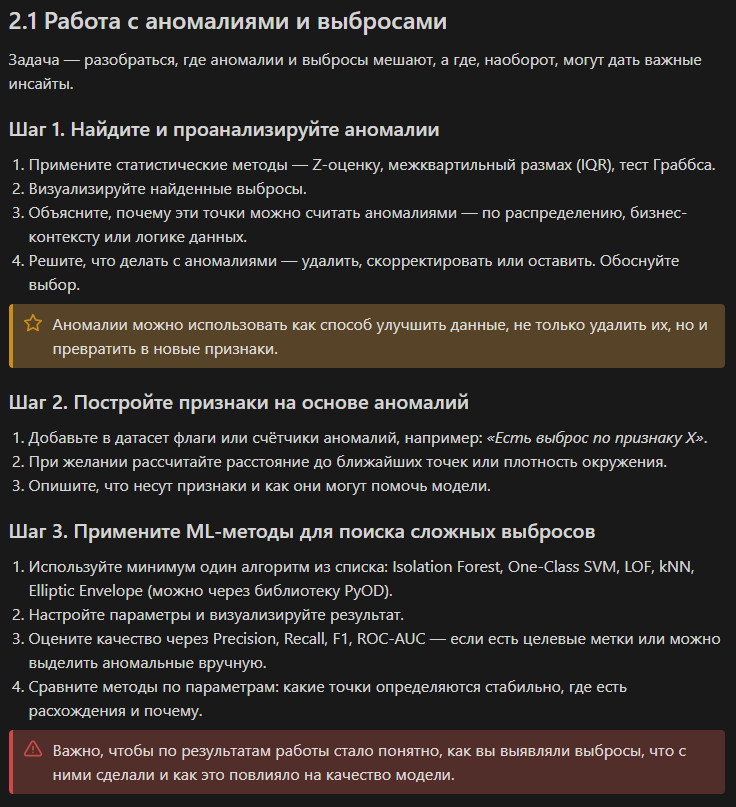

In [110]:
# работаем с df_vis
df_vis

country code  year            cause  deaths
0       Afghanistan  AFG  2007       meningitis  2933.0
1       Afghanistan  AFG  2008       meningitis  2731.0
2       Afghanistan  AFG  2009       meningitis  2460.0
3       Afghanistan  AFG  2011       meningitis  2327.0
4       Afghanistan  AFG  2012       meningitis  2254.0
...             ...  ...   ...              ...     ...
232411     Zimbabwe  ZWE  2015  acute_hepatitis   146.0
232412     Zimbabwe  ZWE  2016  acute_hepatitis   146.0
232413     Zimbabwe  ZWE  2017  acute_hepatitis   144.0
232414     Zimbabwe  ZWE  2018  acute_hepatitis   139.0
232415     Zimbabwe  ZWE  2019  acute_hepatitis   136.0

[232416 rows x 5 columns]

#### Шаг 1

Начнем исследование аномалий с применения IQR на признак deaths.

In [111]:
def iqr_stats(series: pd.Series, factor: float = 1.5):
    """
    Возвращает границы IQR и маску выбросов для одной числовой серии.
    """
    s = series.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr

    mask = (series < lower) | (series > upper)

    return {
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower": lower,
        "upper": upper,
        "mask": mask,
    }

iqr_info = iqr_stats(df_vis["deaths"], factor=1.5)
print(iqr_info["lower"], iqr_info["upper"])
df_vis[iqr_info["mask"]].sort_values("deaths", ascending=False)

-4940.0 8284.0


country      code  year                    cause      deaths
86927        World  OWID_WRL  2019  cardiovascular_diseases  18562510.0
86926        World  OWID_WRL  2018  cardiovascular_diseases  18124018.0
86925        World  OWID_WRL  2017  cardiovascular_diseases  17695752.0
86924        World  OWID_WRL  2016  cardiovascular_diseases  17408326.0
86923        World  OWID_WRL  2015  cardiovascular_diseases  17099164.0
...            ...       ...   ...                      ...         ...
11987     Pakistan       PAK  2010     alzheimer's_diesease      8288.0
125906       Ghana       GHA  2007       diarrheal_diseases      8287.0
210165  Uzbekistan       UZB  1997   chronic_liver_diseases      8285.0
213224   Guatemala       GTM  2018       digestive_diseases      8285.0
13558     Thailand       THA  2000     alzheimer's_diesease      8285.0

[36968 rows x 5 columns]

Можем увидить довольно грубые результаты, поскольку IQR применялся глобально по всем причинам ('cause'). Попробуем найти выбросы с помощью IQR по каждой причине отдельно.

In [112]:
def iqr_outlier_mask(series: pd.Series, factor: float = 1.5) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return (series < lower) | (series > upper)


iqr_local_temp = df_vis.copy()

# Выбросы по каждой причине смерти отдельно
iqr_local_temp["is_outlier_iqr_cause"] = (
    iqr_local_temp.groupby("cause")["deaths"]
      .transform(iqr_outlier_mask)
)

outliers_cause = iqr_local_temp[iqr_local_temp["is_outlier_iqr_cause"]].sort_values("deaths", ascending=False)
outliers_cause

country      code  year                         cause      deaths  \
86927        World  OWID_WRL  2019       cardiovascular_diseases  18562510.0   
86926        World  OWID_WRL  2018       cardiovascular_diseases  18124018.0   
86925        World  OWID_WRL  2017       cardiovascular_diseases  17695752.0   
86924        World  OWID_WRL  2016       cardiovascular_diseases  17408326.0   
86923        World  OWID_WRL  2015       cardiovascular_diseases  17099164.0   
...            ...       ...   ...                           ...         ...   
117063      Brazil       BRA  2017  exposure_to_forces_of_nature        63.0   
120336  Mozambique       MOZ  2016  exposure_to_forces_of_nature        63.0   
118646       Ghana       GHA  2010  exposure_to_forces_of_nature        63.0   
119096        Iran       IRN  2015  exposure_to_forces_of_nature        63.0   
123383       Yemen       YEM  2001  exposure_to_forces_of_nature        63.0   

        is_outlier_iqr_cause  
86927                   True  
86926                   True  
86925                   True  
86924                   True  
86923                   True  
...                      ...  
117063                  True  
120336                  True  
118646                  True  
119096                  True  
123383                  True  

[35635 rows x 6 columns]

Результаты получились более точными, и мы смогли уменьшить количество потенциальных выбросов (35635 против 36968).

Ниже построим scatterplot по выбросам.

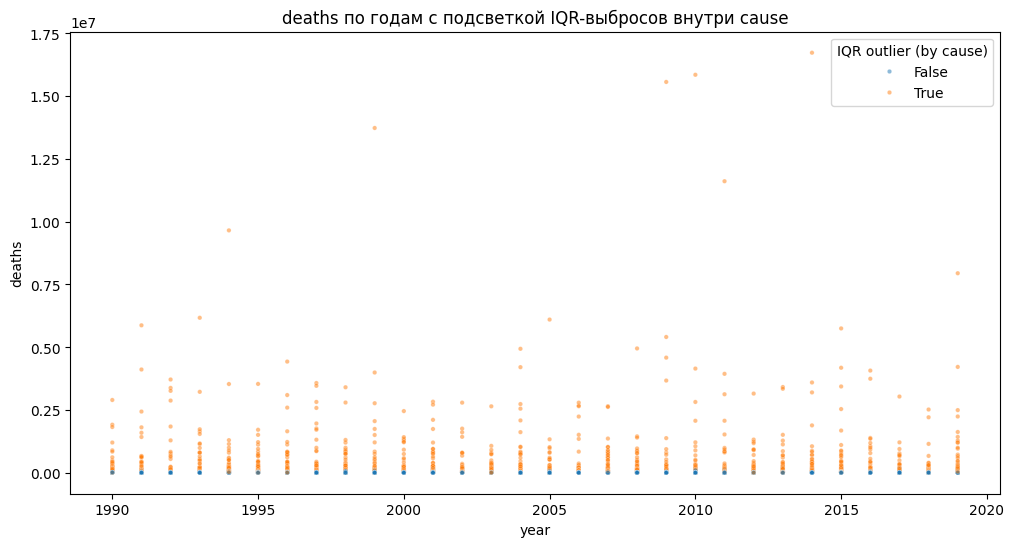

In [113]:
iqr_local_temp = iqr_local_temp.sample(20000, random_state=42) if len(iqr_local_temp) > 20000 else iqr_local_temp

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=iqr_local_temp,
    x="year",
    y="deaths",
    hue="is_outlier_iqr_cause",
    alpha=0.5,
    s=10
)
plt.title("deaths по годам с подсветкой IQR-выбросов внутри cause")
plt.xlabel("year")
plt.ylabel("deaths")
plt.legend(title="IQR outlier (by cause)")
plt.show()

**1. Почему эти точки можно считать аномалиями**

**Глобальный IQR (по всему датасету)**

При применении IQR ко всем значениям `deaths` верхняя граница «хороших» значений составляет примерно **8300**.  
Однако в данных присутствуют наблюдения масштаба **10–20 миллионов смертей**, например:

- *World — cardiovascular_diseases, 2015–2019:* от ≈17 млн до ≈18.5 млн.

Такие точки попадают в выбросы по следующим причинам:

**(a) Статистическое распределение**

- Распределение смертей является сильно правоскошенным.
- Большинство стран имеют значения в пределах **0–10 000**, тогда как агрегаты уровня 'World', 'G20', 'World Bank Upper Middle Income', 'East Asia & Pacific (WB)' достигают **миллионов**.
- Классический IQR плохо подходит для таких распределений, так как предполагает относительную компактность и симметричность данных.

**(b) Логика данных**

- Строки с `country = "World"` — агрегированные показатели смертности по всей планете.
- По своей природе они должны быть значительно выше данных по отдельным странам.
- Значения статистически выбиваются, но **не являются ошибками**.

**(c) Бизнес-контекст**

- Такие значения — реальные глобальные суммы, а не шум или сбой.
- Следовательно, они статистически аномальны, но логически валидны.

---

**IQR по каждой причине (`cause`) отдельно**

После группировки по `cause` количество выбросов уменьшается, но остаются:

- глобальные агрегаты “World”,
- локальные экстремумы в отдельных странах и годах.

Это объясняется следующими факторами:

**(a) Гетерогенность внутри причин смерти**

- Например, для *meningitis* большая часть стран имеет сотни/тысячи смертей, однако в отдельные годы появляются резкие всплески — вероятные эпидемии.

**(b) IQR работает лучше, но остаётся несовершенным**

- Распределения по причинам остаются:
  - асимметричными,
  - редкими всплесками,
  - зависимыми от численности населения стран.

**(c) Контекстные пики**

Такие точки могут отражать:

- реальные эпидемии,
- вспышки болезней,
- стихийные бедствия,
- ошибки отчётности.

Поэтому их корректно рассматривать как потенциальные аномалии,  
но **не удалять без дополнительного анализа**.

---

**2. Что делать с найденными аномалиями — удалить, скорректировать или оставить?**

Разделим аномалии на два типа.

---

**Аномалии типа “World” (агрегаты)**  

-> оставить в данных, но исключить из моделирования

Причины:

- Значения валидные и отражают глобальные суммы смертей.
- Не являются ошибками — просто имеют другой порядок величин.
- В модели такие точки внесут сильный дисбаланс и исказят распределения.

---

**Аномалии внутри отдельных причин смерти (локальные пики)**  

-> не удалять, а пометить бинарным флагом (`outlier_flag`)

Обоснование:

- Могут отражать реальные важные события: эпидемии, войны, катастрофы.
- Удаление приведёт к потере информации.
- Усечение может скрыть всплески, важные для анализа.


##### Zero deaths investigation

In [114]:
zero_deaths = df_vis[df_vis["deaths"] == 0]

zero_deaths

country code  year            cause  deaths
150                          Andorra  AND  1990       meningitis     0.0
151                          Andorra  AND  1991       meningitis     0.0
152                          Andorra  AND  1992       meningitis     0.0
153                          Andorra  AND  1993       meningitis     0.0
154                          Andorra  AND  1994       meningitis     0.0
...                              ...  ...   ...              ...     ...
231912  United States Virgin Islands  VIR  2015  acute_hepatitis     0.0
231913  United States Virgin Islands  VIR  2016  acute_hepatitis     0.0
231914  United States Virgin Islands  VIR  2017  acute_hepatitis     0.0
231915  United States Virgin Islands  VIR  2018  acute_hepatitis     0.0
231916  United States Virgin Islands  VIR  2019  acute_hepatitis     0.0

[17387 rows x 5 columns]

In [115]:
possible_zero_causes = zero_deaths["cause"].unique()

data_tmp = {
    "cause": [],
    "zeros": []
}

for cause in possible_zero_causes:
    data_tmp["cause"].append(cause)
    data_tmp["zeros"].append(len(zero_deaths[zero_deaths["cause"] == cause]))

causes_by_zero_deaths = pd.DataFrame(data=data_tmp).sort_values(["zeros"], ascending=False)

causes_by_zero_deaths

cause  zeros
4                                malaria   3597
15          exposure_to_forces_of_nature   3483
18                conflict_and_terrorism   3248
17  environmental_heat_and_cold_exposure    841
27                       acute_hepatitis    840
22                             terrorism    811
20                            poisonings    584
9                     drug_use_disorders    580
7                     maternal_disorders    426
21           protein_energy_malnutrition    413
26               fire_heat_hot_substance    334
0                             meningitis    316
3                 nutritional_deficiency    283
13                 alcohol_use_disorders    279
8                               hiv/aids    235
10                          tuberculosis    196
6                 interpersonal_violence    165
16                    diarrheal_diseases    159
5                               drowning    120
12                    neonatal_disorders     91
2                    parkinson's_disease     90
1                   alzheimer's_diesease     78
23                         road_injuries     60
14                             self_harm     60
24                chronic_liver_diseases     51
19                chronic_kidney_disease     24
25                    digestive_diseases     17
11          lower_respiratory_infections      6

In [ ]:
causes = causes_by_zero_deaths[causes_by_zero_deaths["zeros"] > 100]["cause"]
step = 10

for cause in causes:
    print(f"Countries for {cause}")

    countries = df_vis[(df_vis["cause"] == cause) & (df_vis["deaths"] > 10)]["country"].unique()
    print(",\n".join([",".join(countries[i:i + step]) for i in range(0, len(countries), step)]))
    print("\n")

Countries for malaria
Afghanistan,African Region (WHO),Algeria,Angola,Bangladesh,Benin,Bhutan,Bolivia,Botswana,Brazil,
Burkina Faso,Burundi,Cambodia,Cameroon,Central African Republic,Chad,China,Colombia,Comoros,Congo,
Cote d'Ivoire,Democratic Republic of Congo,Djibouti,Dominican Republic,East Asia & Pacific (WB),Eastern Mediterranean Region (WHO),Ecuador,Equatorial Guinea,Eritrea,Eswatini,
Ethiopia,Europe & Central Asia (WB),European Region (WHO),G20,Gabon,Gambia,Ghana,Guatemala,Guinea,Guinea-Bissau,
Guyana,Haiti,Honduras,India,Indonesia,Iran,Kenya,Laos,Latin America & Caribbean (WB),Liberia,
Madagascar,Malawi,Malaysia,Mali,Mauritania,Mexico,Middle East & North Africa (WB),Mozambique,Myanmar,Namibia,
Nepal,Nicaragua,Niger,Nigeria,OECD Countries,Oman,Pakistan,Papua New Guinea,Peru,Philippines,
Region of the Americas (WHO),Rwanda,Sao Tome and Principe,Saudi Arabia,Senegal,Sierra Leone,Solomon Islands,Somalia,South Africa,South Asia (WB),
South Korea,South Sudan,South-East Asia Region (WH

Отсюда в дальшнейшем можно вдохновится разбиением 'cause' по регионам вспышки болезни

#### Шаг 2

На основе исследований на шаге 1, добавим новый признак для экстремальных значений вне стран-аггрегатов ('World', 'G20', ...)

In [ ]:
outliers_cause["country"].unique()

array(['World', 'G20', 'World Bank Upper Middle Income',
       'East Asia & Pacific (WB)', 'World Bank Lower Middle Income',
       'Western Pacific Region (WHO)', 'China', 'European Region (WHO)',
       'Europe & Central Asia (WB)', 'South-East Asia Region (WHO)',
       'OECD Countries', 'World Bank High Income', 'South Asia (WB)',
       'India', 'Region of the Americas (WHO)', 'Sub-Saharan Africa (WB)',
       'African Region (WHO)', 'Eastern Mediterranean Region (WHO)',
       'Russia', 'Latin America & Caribbean (WB)', 'North America (WB)',
       'Middle East & North Africa (WB)', 'United States',
       'World Bank Low Income', 'Indonesia', 'Rwanda', 'Ukraine',
       'Germany', 'Japan', 'Brazil', 'Pakistan', 'Bangladesh',
       'South Africa', 'Nigeria', 'United Kingdom', 'Egypt', 'Vietnam',
       'England', 'Italy', 'Haiti', 'Philippines', 'Poland', 'France',
       'Turkey', 'Iran', 'Mexico', 'Romania', 'Myanmar', 'Kenya', 'Spain',
       'Tanzania', 'Ethiopia', 'Thailan

In [ ]:
region_agg = [
       'World', 'G20', 'World Bank Upper Middle Income',
       'East Asia & Pacific (WB)', 'World Bank Lower Middle Income',
       'Western Pacific Region (WHO)', 'European Region (WHO)',
       'Europe & Central Asia (WB)', 'South-East Asia Region (WHO)',
       'OECD Countries', 'World Bank High Income', 'South Asia (WB)',
       'Region of the Americas (WHO)', 'Sub-Saharan Africa (WB)',
       'African Region (WHO)', 'Eastern Mediterranean Region (WHO)',
       'Latin America & Caribbean (WB)', 'North America (WB)',
       'Middle East & North Africa (WB)', 'World Bank Low Income',
       'Middle East & North Africa', 'Sub-Saharan Africa',
       'South Asia', 'North America', 'South America', 'Eastern Europe',
       'Southeast Asia', 'Central America & Caribbean', 'East Asia',
       'Central Asia', 'Western Europe',
]

In [ ]:
len(outliers_cause[outliers_cause["country"].isin(region_agg)])

18022

In [ ]:
df_vis["outlier_flag"] = np.zeros((len(df_vis)))

df_vis.loc[outliers_cause[~outliers_cause["country"].isin(region_agg)].index] = 1

In [ ]:
df_vis["outlier_flag"].value_counts()

outlier_flag
0.0    214803
1.0     17613
Name: count, dtype: int64

#### Шаг 3

### Генерация признаков

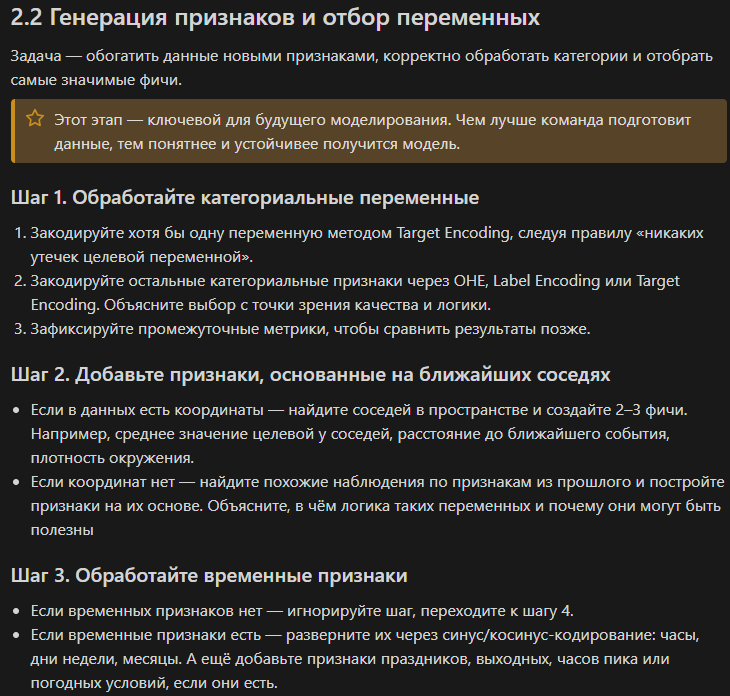

#### Шаг 1

#### Шаг 2

Тут мы пытаемся найти "соседей" по схожести временных рядов, для этого используем двухвыборочный критерий Колмогорова-Смирнова. Будем рассматривать временной ряд смертей в какой-то стране как выборку из непрерывного распредления и будем сравнивать с такой же сущностью в другой стране и смотреть насколько эти ряды схожи.

Если получим высокий p-value, значит динамики смертности от какой-то причины в этих странах схожи.

In [ ]:
def find_similar_countries(df, target_country, target_cause, p_value_threshold=0.05):
    """
    Находит страны с похожей динамикой смертности для заданной причиной смерти
    """
    similar_countries = []

    target_series = df[(df['country'] == target_country) & (df['cause'] == target_cause)]['deaths'].values
    if len(target_series) == 0:
        return []

    # Проходимся во всем остальным странам
    for country_name in df['country'].unique():
        if country_name == target_country:
            continue

        compare_series = df[(df['country'] == country_name) & (df['cause'] == target_cause)]['deaths'].values
        if len(compare_series) == 0:
            continue

        # Проводим тест с использованием двухвыборочного критерия Колмогорова-Смирнова
        ks_statistic, p_value = ks_2samp(target_series, compare_series)

        # Сравниваем с трешхолдом на похожесть
        if p_value > p_value_threshold:
            similar_countries.append(country_name)

    return similar_countries

def create_similarity_dict(df, p_value_threshold=0.05):
    """
    Создает и возвращает словарь похожих стран
    """
    similarity_dict = {}
    unique_causes = df['cause'].unique()

    for cause in tqdm(unique_causes, desc="We are waiting for this ****"):
        similarity_dict[cause] = {}
        df_cause = df[df['cause'] == cause]

        for target_country in df_cause['country'].unique():
            sim_countries = find_similar_countries(df, target_country, cause, p_value_threshold)
            similarity_dict[cause][target_country] = sim_countries
    return similarity_dict

def vectorized_sim_group_features(df, similarity_dict):
    """
    Рассчитывает средние характеристики по похожим странам
    """

    df_vis = df.copy()
    records = []
    for cause, country_data in similarity_dict.items():
        for country, peers in country_data.items():
            for peer in peers:
                records.append((cause, country, peer))

    if not records:
        print("Не найдено ни одной похожей страны")
        df_vis['peer_group_avg_deaths'] = np.nan
        return df_vis

    mapping_df = pd.DataFrame(records, columns=['cause', 'country', 'peer_country'])

    # Готовим данные о смертях соседей для мержа
    deaths_for_peers = df_vis[['country', 'cause', 'year', 'deaths']].rename(
        columns={'country': 'peer_country', 'deaths': 'peer_deaths'}
    )

    # Соединяем каждую страну с данными ее соседей
    merged_df = pd.merge(
        mapping_df,
        deaths_for_peers,
        on=['peer_country', 'cause', 'year'],
        how='left'
    )

    # Считаем среднее по соседям
    peer_group_averages = merged_df.groupby(['country', 'cause', 'year'])['peer_deaths'].mean().reset_index()
    peer_group_averages = peer_group_averages.rename(columns={'peer_deaths': 'peer_group_avg_deaths'})

    # Присоединяем новый признак к основному датафрейму
    df_with_features = pd.merge(
        df_vis,
        peer_group_averages,
        on=['country', 'cause', 'year'],
        how='left'
    )

    # Обработка пропусков: если для страны не нашлось соседей, ее 'peer_group_avg_deaths' будет NaN. Заполним его средним по миру для этой причины/года.
    global_avg_for_cause = df_vis.groupby(['cause', 'year'])['deaths'].mean().reset_index()
    global_avg_for_cause = global_avg_for_cause.rename(columns={'deaths': 'global_avg_for_cause'})

    df_with_features = pd.merge(df_with_features, global_avg_for_cause, on=['cause', 'year'], how='left')
    df_with_features['peer_group_avg_deaths'].fillna(df_with_features['global_avg_for_cause'], inplace=True)
    df_with_features.drop('global_avg_for_cause', axis=1, inplace=True)

    print("Признак 'peer_group_avg_deaths' успешно создан и добавлен!")
    return df_with_features


In [ ]:
# Рассмотрим на примере
target_country = 'Afghanistan'
target_cause = 'meningitis'
sim_countries = find_similar_countries(df_vis, target_country, target_cause)

print(f"Страны, похожие на '{target_country}' по причине смерти '{target_cause}':")
print(sim_countries)

Страны, похожие на 'Afghanistan' по причине смерти 'meningitis':
['Bangladesh', 'Brazil', 'Madagascar', 'Malawi', 'Mozambique', 'Myanmar', 'Senegal', 'Somalia', 'South Africa', 'Uganda']


In [ ]:
sim_group_deaths = df_vis[df_vis['country'].isin(sim_countries) & (df_vis['cause'] == target_cause)].groupby('year')['deaths'].mean().reset_index().rename(columns={'deaths': 'peer_group_avg_deaths'})
print("Новый признак:")
print(sim_group_deaths.head())

Новый признак:
   year  peer_group_avg_deaths
0  1990                 2639.4
1  1991                 2573.4
2  1992                 2595.2
3  1993                 2556.4
4  1994                 2555.6


Теперь начнем тяжелый цикл... (у меня он будет выполняться не меньше 5 часов)(возможно это перебор)

In [ ]:
# similarity_dict = create_similarity_dict(df_vis)

In [ ]:
#df_with_features = vectorized_sim_group_features(df_vis, similarity_dict)
#print(df_with_features.tail())

In [ ]:
# сохраним в файл, чтобы в следующий раз не ждать, пока выполнится
output_filename = 'dataframe_with_peer_features.pkl'

try:
    with open(output_filename, 'wb') as file:
        pickle.dump(df_with_features, file)
    print(f"df успешно сохранен в файл: {output_filename}")
except Exception as e:
    print(f"Произошла ошибка при сохранении файла: {e}")

Произошла ошибка при сохранении файла: name 'df_with_features' is not defined


In [ ]:
# Проверяем, что сохранилось
try:
    with open(output_filename, 'rb') as file:
        loaded_df = pickle.load(file)
    print(f"df успешно загружен из файла. Размер: {loaded_df.shape}")
    print("Последние 5 строк загруженного df:")
    print(loaded_df.tail())
except FileNotFoundError:
    print(f"Файл {output_filename} не найден. Убедитесь, что он был сохранен.")
except Exception as e:
    print(f"Произошла ошибка при загрузке файла: {e}")

Произошла ошибка при загрузке файла: Ran out of input


#### Шаг 3

Тут развернем временные признаки через богатые фичи фурье вплоть до 3 степени и посмотрим улучшит ли это работу CatBoost-а.

In [ ]:
def generate_time_features(df, time_col='year'):
    """Генерирует трендовые и Фурье-признаки."""
    df_out = df.copy()

    df_out['time_index'] = df_out[time_col] - df_out[time_col].min()

    # Те Самые Богатые Фичи Фурье
    periods = [5, 10, 15]
    n_harmonics = 3

    for period in periods:
        for i in range(1, n_harmonics + 1):
            df_out[f'sin_{period}y_{i}'] = np.sin(2 * np.pi * i * df_out['time_index'] / period)
            df_out[f'cos_{period}y_{i}'] = np.cos(2 * np.pi * i * df_out['time_index'] / period)

    return df_out

Рассмотрим улучшение предсказаний на примере США с ССЗ

In [ ]:
us_cvd = df_cleaned[df_cleaned['country'] == 'United States'][['year', 'cardiovascular_diseases']].sort_values('year').reset_index(drop=True)
us_cvd_with_features = generate_time_features(us_cvd)

y = us_cvd_with_features['cardiovascular_diseases']

X_before = us_cvd_with_features[['year']]
X_after = us_cvd_with_features.drop(['year', 'cardiovascular_diseases'], axis=1)
train_size = len(us_cvd_with_features) - 5 # последние 5 лет - на тест

y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]
X_train_before, X_val_before = X_before.iloc[:train_size], X_before.iloc[train_size:]
X_train_after, X_val_after = X_after.iloc[:train_size], X_after.iloc[train_size:]

In [ ]:
model_before = CatBoostRegressor(iterations=200, verbose=0, random_seed=42)
model_before.fit(X_train_before, y_train)
preds_before = model_before.predict(X_val_before)
mae_before = mean_absolute_error(y_val, preds_before)

model_after = CatBoostRegressor(iterations=200, verbose=0, random_seed=42)
model_after.fit(X_train_after, y_train)
preds_after = model_after.predict(X_val_after)
mae_after = mean_absolute_error(y_val, preds_after)

print(f"MAE модели (только с признаком 'year'): {mae_before:,.0f}")
print(f"MAE модели (с трендом и Фурье-фичами): {mae_after:,.0f}")
print()
improvement = (mae_before - mae_after) / mae_before * 100
print(f"Улучшение качества прогноза: {improvement:.2f}%")

MAE модели (только с признаком 'year'): 53,171
MAE модели (с трендом и Фурье-фичами): 48,631

Улучшение качества прогноза: 8.54%


Также посмотрим какие признаки CatBoost посчитал наиболее важными

/tmp/ipython-input-3472236036.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


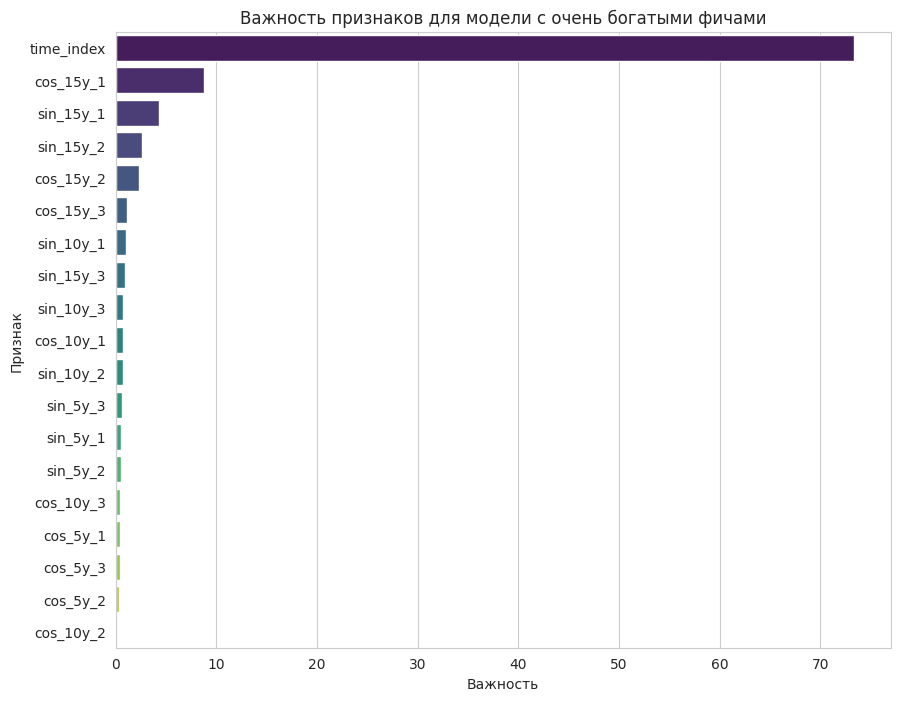

In [ ]:
feature_importance = pd.Series(
    model_after.get_feature_importance(),
    index=X_after.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Важность признаков для модели с очень богатыми фичами')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

### Отбор переменных и таргет ресерч

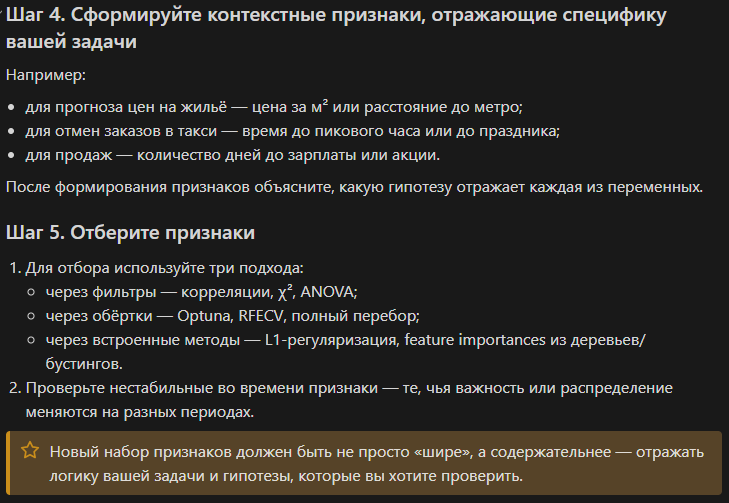

#### Шаг 4

In [ ]:
df_cleaned.sort_values("year", inplace=True)
df_cleaned

country code  year  meningitis  alzheimer's_diesease  \
3379               Lebanon  LBN  1990        56.0                 363.0   
90                 Algeria  DZA  1990       838.0                1337.0   
5925                 Spain  ESP  1990       370.0               11872.0   
3349                Latvia  LVA  1990        55.0                 610.0   
1038                Canada  CAN  1990       128.0                6456.0   
...                    ...  ...   ...         ...                   ...   
4342             Nicaragua  NIC  2019        44.0                 706.0   
59    African Region (WHO)  NaN  2019    139590.0               66124.0   
7272              Zimbabwe  ZWE  2019      1450.0                 812.0   
7242                Zambia  ZMB  2019      2065.0                 763.0   
29             Afghanistan  AFG  2019      1563.0                1775.0   

      parkinson's_disease  nutritional_deficiency   malaria  drowning  \
3379                 83.0                    15.0       0.0      77.0   
90                  439.0                   453.0       9.0    1207.0   
5925               2685.0                   205.0       0.0     837.0   
3349                156.0                    26.0       0.0     441.0   
1038               1545.0                   216.0       0.0     404.0   
...                   ...                     ...       ...       ...   
4342                218.0                   145.0       3.0     172.0   
59                15930.0                 98704.0  590252.0   23768.0   
7272                232.0                  2884.0    2068.0     827.0   
7242                203.0                  1899.0    4777.0     359.0   
29                  560.0                  1244.0     530.0    1687.0   

      interpersonal_violence  ...  chronic_kidney_disease  poisonings  \
3379                  1378.0  ...                   621.0        35.0   
90                     491.0  ...                  3559.0       485.0   
5925                   445.0  ...                  7675.0       208.0   
3349                   279.0  ...                    79.0        87.0   
1038                   627.0  ...                  2642.0       179.0   
...                      ...  ...                     ...         ...   
4342                   395.0  ...                  3475.0        22.0   
59                   79735.0  ...                127158.0     18792.0   
7272                  1434.0  ...                  2292.0       405.0   
7242                  1616.0  ...                  1931.0       309.0   
29                    5015.0  ...                  5637.0       525.0   

      protein_energy_malnutrition  terrorism  road_injuries  \
3379                         13.0      113.0          387.0   
90                          422.0        3.0        13438.0   
5925                        117.0       32.0         9336.0   
3349                         11.0        NaN          934.0   
1038                        160.0        NaN         4282.0   
...                           ...        ...            ...   
4342                        143.0        NaN          742.0   
59                        94780.0        NaN       182243.0   
7272                       2855.0        NaN         2554.0   
7242                       1828.0        NaN         2285.0   
29                         1210.0        NaN         8254.0   

      chronic_respiratory_diseases  chronic_liver_diseases  \
3379                         695.0                   358.0   
90                          4410.0                  2401.0   
5925                       22694.0                 11525.0   
3349                         750.0                   248.0   
1038                        9319.0                  3144.0   
...                            ...                     ...   
4342                        1343.0                  1623.0   
59                        178908.0                187968.0   
7272                        2891.0               

In [ ]:
df_cleaned

target = df_cleaned[(df_cleaned["country"] == "United States")]["cardiovascular_diseases"]
years_us = df_cleaned[df_cleaned["country"] == "United States"]["year"].dropna()
common_years = target.index.intersection(years_us.index)
target = target.loc[common_years]
target.head(5)

6714    879646.0
6715    877798.0
6716    874992.0
6717    895086.0
6718    899691.0
Name: cardiovascular_diseases, dtype: float64

In [ ]:
df_cleaned.head()

country code  year  meningitis  alzheimer's_diesease  \
3379  Lebanon  LBN  1990        56.0                 363.0   
90    Algeria  DZA  1990       838.0                1337.0   
5925    Spain  ESP  1990       370.0               11872.0   
3349   Latvia  LVA  1990        55.0                 610.0   
1038   Canada  CAN  1990       128.0                6456.0   

      parkinson's_disease  nutritional_deficiency  malaria  drowning  \
3379                 83.0                    15.0      0.0      77.0   
90                  439.0                   453.0      9.0    1207.0   
5925               2685.0                   205.0      0.0     837.0   
3349                156.0                    26.0      0.0     441.0   
1038               1545.0                   216.0      0.0     404.0   

      interpersonal_violence  ...  chronic_kidney_disease  poisonings  \
3379                  1378.0  ...                   621.0        35.0   
90                     491.0  ...                  3559.0       485.0   
5925                   445.0  ...                  7675.0       208.0   
3349                   279.0  ...                    79.0        87.0   
1038                   627.0  ...                  2642.0       179.0   

      protein_energy_malnutrition  terrorism  road_injuries  \
3379                         13.0      113.0          387.0   
90                          422.0        3.0        13438.0   
5925                        117.0       32.0         9336.0   
3349                         11.0        NaN          934.0   
1038                        160.0        NaN         4282.0   

      chronic_respiratory_diseases  chronic_liver_diseases  \
3379                         695.0                   358.0   
90                          4410.0                  2401.0   
5925                       22694.0                 11525.0   
3349                         750.0                   248.0   
1038                        9319.0                  3144.0   

      digestive_diseases  fire_heat_hot_substance  acute_hepatitis  
3379               567.0                    135.0            166.0  
90                3981.0                   1113.0            486.0  
5925             20287.0                    338.0             17.0  
3349               798.0                    257.0             24.0  
1038              7296.0                    446.0             15.0  

[5 rows x 35 columns]

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


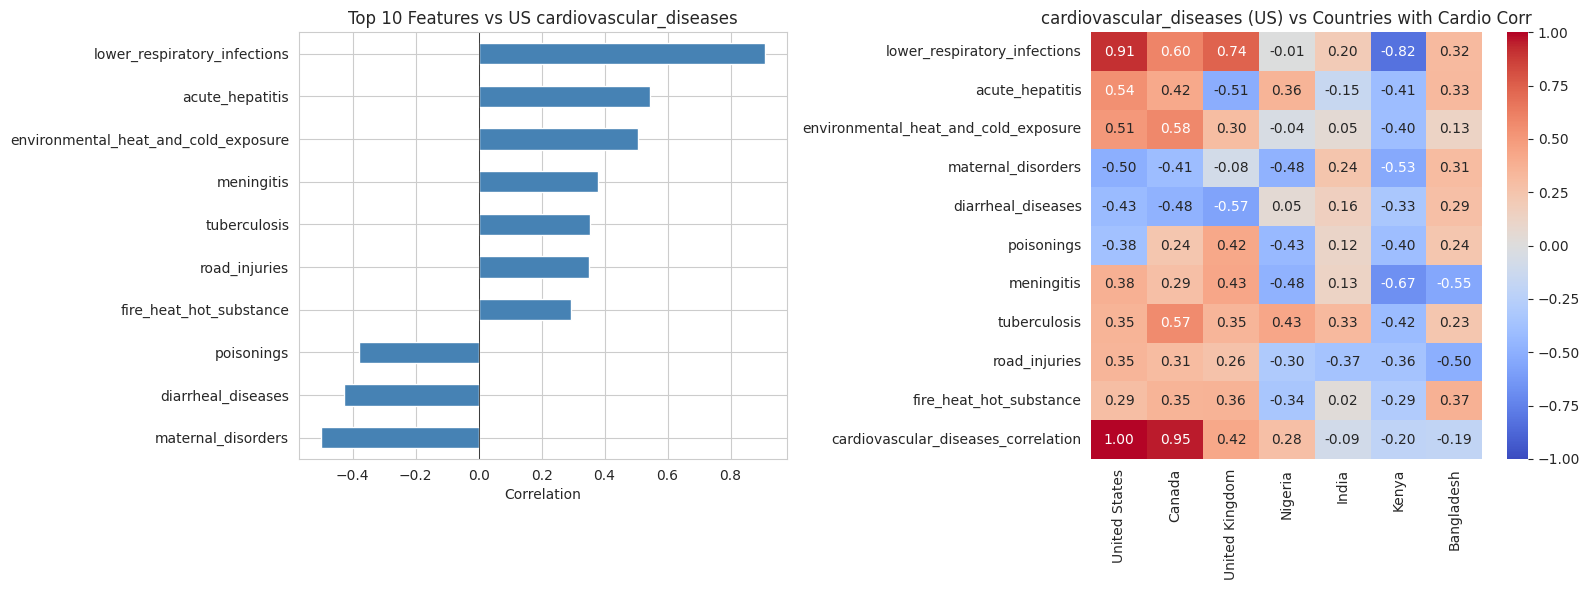

In [ ]:
target_col = "cardiovascular_diseases"
countries = ["United States", "Canada", "United Kingdom", "Nigeria", "India", "Kenya", "Bangladesh"]

target_us = df_cleaned[df_cleaned["country"] == "United States"].set_index("year")[target_col]

df_us = df_cleaned[df_cleaned["country"] == "United States"].set_index("year")
X_us = df_us.select_dtypes(include='number').drop(columns=[target_col], errors='ignore')
corr_us = X_us.corrwith(target_us)
top_features = corr_us.abs().sort_values(ascending=False).head(10).index

results = {}
for country in countries:
    df_c = df_cleaned[df_cleaned["country"] == country].set_index("year")
    if not df_c.empty:
        corrs = {}
        for feature in top_features:
            if feature in df_c.columns:
                common_years = df_c.index.intersection(target_us.index)
                if len(common_years) >= 3:
                    x = df_c.loc[common_years, feature]
                    y = target_us.loc[common_years]
                    corrs[feature] = x.corr(y)
        if target_col in df_c.columns:
            common_years = df_c.index.intersection(target_us.index)
            if len(common_years) >= 3:
                x = df_c.loc[common_years, target_col]
                y = target_us.loc[common_years]
                corrs[f"{target_col}_correlation"] = x.corr(y)
        results[country] = corrs

df_compare = pd.DataFrame(results).fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

corr_us[top_features].sort_values().plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title(f'Top 10 Features vs US {target_col}')
ax1.set_xlabel('Correlation')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

sns.heatmap(df_compare, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1, ax=ax2, fmt='.2f')
ax2.set_title(f'{target_col} (US) vs Countries with Cardio Corr')

plt.tight_layout()
plt.show()


In [ ]:
top7_us = corr_us.abs().sort_values(ascending=False).head(7).index.tolist()
numeric_cols = [col for col in df_cleaned.select_dtypes(include='number').columns if col not in [target_col, 'year']]
global_corr_vals = df_cleaned[[target_col] + numeric_cols].corr()[target_col].abs().sort_values(ascending=False)
top5_global = [col for col in global_corr_vals.index if col in numeric_cols][:5]
all_features = list(set(top7_us + top5_global))

df_final = pd.DataFrame({'year': target_us.index, target_col: target_us.values})

countries_short = ["US", "Canada", "UK", "Nigeria", "India", "Kenya", "Bangladesh"]
for i, country in enumerate(countries):
    df_c = df_cleaned[df_cleaned["country"] == country].set_index("year")
    available_features = [f for f in all_features if f in df_c.columns]
    if available_features:
        top_feature = corr_us.loc[available_features].abs().idxmax()
        common_years = set(df_final['year']).intersection(set(df_c.index))
        df_final[f"{countries_short[i]}_{top_feature}"] = df_final['year'].map(df_c[top_feature])

df_final.head()

year  cardiovascular_diseases  US_lower_respiratory_infections  \
0  1990                 879646.0                          72716.0   
1  1991                 877798.0                          73655.0   
2  1992                 874992.0                          74500.0   
3  1993                 895086.0                          77518.0   
4  1994                 899691.0                          78885.0   

   Canada_lower_respiratory_infections  UK_lower_respiratory_infections  \
0                               6576.0                          37837.0   
1                               6761.0                          38841.0   
2                               6945.0                          40369.0   
3                               7239.0                          44991.0   
4                               7465.0                          46463.0   

   Nigeria_lower_respiratory_infections  India_lower_respiratory_infections  \
0                              169472.0                            690913.0   
1                              174686.0                            682280.0   
2                              180284.0                            675001.0   
3                              185946.0                            656565.0   
4                              192168.0                            639401.0   

   Kenya_lower_respiratory_infections  Bangladesh_lower_respiratory_infections  
0                             22170.0                                 113930.0  
1                             21640.0                                 111469.0  
2                             21291.0                                 108444.0  
3                             20962.0                                 105407.0  
4                             20637.0                                 102806.0

Причины смерти, наиболее коррелирующие с сердечно-сосудистыми заболеваниями в США Признаки, такие как смертность от `lower_respiratory_infections` или `acute_hepatitis`, встроены в датасет для каждой страны. Они подобраны по максимальной корреляции с таргетом (`cardiovascular_diseases`) в США и отражают общее состояние системы здравоохранения, экологии и образа жизни населения.
Для каждой страны добавляется собственный наиболее релевантный признак (например, `Nigeria_lower_respiratory_infections`). Эти переменные отражают гипотезу: факторы, влияющие на смертность от сердечно-сосудистых болезней в одной стране, могут по-разному проявляться в других странах из-за различий в уровне медицины, социально-экономических условиях, климате и традициях. Анализ показывает проактивные показатели у развитых атлантических (саксонских) стран, при этом, слаборазвитые страны плохо коррелируют с показателями из США - для предсказывания можно использовать данные о странах, в которых социально-экономический и политический бэкграунд схож с исходной.

#### Шаг 5

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, f_regression, RFECV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

X = df_final.drop(columns=["cardiovascular_diseases", "year"])
y = df_final["cardiovascular_diseases"]

tscv = TimeSeriesSplit(n_splits=5)

# 1) L1 + RandomForest feature importances
pipe_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.001, max_iter=10000, random_state=42))
])
pipe_lasso.fit(X, y)
lasso_coef = pd.Series(pipe_lasso.named_steps["model"].coef_, index=X.columns, name="lasso_coef")

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns, name="rf_importance")

feature_importance = pd.concat([lasso_coef, rf_importance], axis=1)
feature_importance["abs_lasso"] = feature_importance["lasso_coef"].abs()
feature_importance = feature_importance.sort_values("abs_lasso", ascending=False)
display("Feature importance (L1 + RF):")
display(feature_importance)

# 2) Xi2 и ANOVA)
X_pos = X - X.min() + 1e-6

chi2_vals, chi2_p = chi2(X_pos, y)
f_vals, f_p = f_regression(X, y)

filter_scores = pd.DataFrame({
    "chi2": chi2_vals,
    "chi2_p": chi2_p,
    "f_val": f_vals,
    "f_p": f_p
}, index=X.columns)
display("Filter scores (chi2, ANOVA):")
display(filter_scores.sort_values("f_val", ascending=False))

# 3) RFECV
estimator = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    min_features_to_select=1
)

rfecv.fit(X, y)

rfecv_support = pd.Series(rfecv.support_, index=X.columns, name="selected")
rfecv_rank = pd.Series(rfecv.ranking_, index=X.columns, name="rank")

rfecv_result = pd.concat([rfecv_support, rfecv_rank], axis=1).sort_values("rank")
display("RFECV results (time-series CV):")
display(rfecv_result)
display("Best number of features (RFECV):", rfecv.n_features_)


'Feature importance (L1 + RF):'

lasso_coef  rf_importance  \
US_lower_respiratory_infections          41371.125833       0.401467   
Canada_lower_respiratory_infections     -36714.449678       0.028535   
Kenya_lower_respiratory_infections      -31376.556945       0.324247   
Nigeria_lower_respiratory_infections    -24577.547982       0.027231   
India_lower_respiratory_infections      -14455.528602       0.016163   
Bangladesh_lower_respiratory_infections -13068.964720       0.017087   
UK_lower_respiratory_infections          -3033.448854       0.185270   

                                            abs_lasso  
US_lower_respiratory_infections          41371.125833  
Canada_lower_respiratory_infections      36714.449678  
Kenya_lower_respiratory_infections       31376.556945  
Nigeria_lower_respiratory_infections     24577.547982  
India_lower_respiratory_infections       14455.528602  
Bangladesh_lower_respiratory_infections  13068.964720  
UK_lower_respiratory_infections           3033.448854

'Filter scores (chi2, ANOVA):'

chi2  chi2_p       f_val  \
US_lower_respiratory_infections          7.511580e+04     0.0  135.703612   
Kenya_lower_respiratory_infections       1.725346e+04     0.0   59.533333   
UK_lower_respiratory_infections          1.307522e+05     0.0   33.748162   
Canada_lower_respiratory_infections      2.154019e+04     0.0   15.423043   
Bangladesh_lower_respiratory_infections  6.593821e+05     0.0    3.149100   
India_lower_respiratory_infections       1.548809e+06     0.0    1.123152   
Nigeria_lower_respiratory_infections     2.069368e+05     0.0    0.000858   

                                                  f_p  
US_lower_respiratory_infections          2.990017e-12  
Kenya_lower_respiratory_infections       2.096031e-08  
UK_lower_respiratory_infections          3.060735e-06  
Canada_lower_respiratory_infections      5.105867e-04  
Bangladesh_lower_respiratory_infections  8.684359e-02  
India_lower_respiratory_infections       2.982977e-01  
Nigeria_lower_respiratory_infections     9.768433e-01

'RFECV results (time-series CV):'

selected  rank
US_lower_respiratory_infections              True     1
Canada_lower_respiratory_infections          True     1
UK_lower_respiratory_infections              True     1
Nigeria_lower_respiratory_infections         True     1
Kenya_lower_respiratory_infections           True     1
India_lower_respiratory_infections          False     2
Bangladesh_lower_respiratory_infections     False     3

'Best number of features (RFECV):'

np.int64(5)

###

## Чекпоинт 3

In [ ]:
df_vis = generate_time_features(df_vis)

### Шаг 1

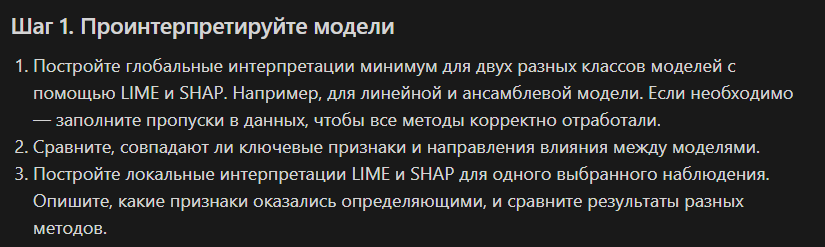

In [ ]:
def make_models_and_eval_metrics(X_train, y_train, X_test, y_test):
    models = {}

    # 1) Linear Regression (со стандартизацией)
    models["LinearRegression"] = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )

    # 2) SVM (SVR с RBF)
    models["SVR"] = make_pipeline(
        StandardScaler(),
        SVR(kernel="rbf", C=10.0, epsilon=0.1)
    )

    # 3) CatBoost
    models["CatBoost"] = CatBoostRegressor(
        depth=6,
        learning_rate=0.05,
        n_estimators=500,
        loss_function="RMSE",
        verbose=False,
        random_seed=42
    )

    # 4) LightGBM
    models["LightGBM"] = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        objective="regression",
        random_state=42,
    )

    metrics = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        metrics[name] = {"MAE": mae, "R2": r2}

    return models, metrics


def train_test_split(df, country, cause):
    df_vis = df.copy()

    df_sub = (
        df_vis
        .loc[(df_vis["country"] == country) & (df_vis["cause"] == cause)]
        .sort_values("year")
        .reset_index(drop=True)
    )

    target_col = "deaths"
    drop_cols = ["index", "country", "code", "year", "cause", "outlier_flag", target_col]

    feature_cols = [c for c in df_sub.columns if c not in drop_cols]

    X = df_sub[feature_cols].copy()
    y = df_sub[target_col].astype(float).copy()


    if X.isna().sum().values.sum() > 0:
        imputer = SimpleImputer(strategy="median")
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)
    else:
        X_imputed = X

    assert len(df_sub) > 11, "Нужно хотя бы 11 наблюдений по стране/причине для 10+1 лет."

    X_train = X_imputed.iloc[-11:-1, :].reset_index(drop=True)
    y_train = y.iloc[-11:-1].reset_index(drop=True)

    X_test = X_imputed.iloc[[-1]].reset_index(drop=True)   # последний год
    y_test = y.iloc[[-1]].reset_index(drop=True)

    return X_train, y_train, X_test, y_test

def global_shap_analysis(models: dict, tree_models: list[str], kernel_models: list[str], X_train: pd.DataFrame):

    feature_cols = X_train.columns
    shap_values_tree = {}

    for name in tree_models:
        model = models[name]
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        shap_values_tree[name] = (explainer, shap_values)

        print(f"=== SHAP summary для {name} ===")
        shap.summary_plot(shap_values, X_train, feature_names=feature_cols)

    # подготовим X_background (маленький бэкграунд для KernelExplainer)
    X_bg = shap.sample(X_train, 50, random_state=42)

    def get_scaled_data(pipe, X):
        # pipe: Pipeline(StandardScaler, Model)
        scaler = pipe.steps[0][1]
        return scaler.transform(X)

    shap_values_kernel = {}

    for name in kernel_models:
        pipe = models[name]
        scaler = pipe.steps[0][1]
        base_model = pipe.steps[1][1]

        X_train_scaled = scaler.transform(X_train)
        X_bg_scaled = scaler.transform(X_bg)

        explainer = shap.KernelExplainer(
            base_model.predict,
            X_bg_scaled
        )

        # расчёт shap только для обучающей выборки
        shap_vals = explainer.shap_values(X_train_scaled, l1_reg="aic")
        shap_values_kernel[name] = (explainer, shap_vals, scaler)

        print(f"=== SHAP summary для {name} ===")
        shap.summary_plot(shap_vals, X_train, feature_names=feature_cols)

    return shap_values_tree, shap_values_kernel


def global_lime_importance(lime_explainer, model: dict, X_train: pd.DataFrame, n_samples=50):
    rng = np.random.default_rng(42)
    idxs = rng.choice(len(X_train), size=min(n_samples, len(X_train)), replace=False)

    n_features = X_train.shape[1]
    agg_importance = np.zeros(n_features, dtype=float)
    counts = np.zeros(n_features, dtype=int)

    for idx in idxs:
        x = X_train.iloc[idx].values

        exp = lime_explainer.explain_instance(
            data_row=x,
            predict_fn=model.predict,
            num_features=n_features,
        )

        # для регрессии в local_exp один ключ — берём его
        label = list(exp.local_exp.keys())[0]

        for feat_idx, weight in exp.local_exp[label]:
            agg_importance[feat_idx] += abs(weight)
            counts[feat_idx] += 1

    counts[counts == 0] = 1  # чтобы не делить на ноль
    importance = agg_importance / counts

    return pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

def local_shap_catboost(models: dict, x_loc, feature_cols):
    cb_model = models["CatBoost"]

    cb_explainer = shap.TreeExplainer(cb_model)
    cb_shap_loc = cb_explainer.shap_values(x_loc)  # shape (1, n_features)
    cb_base = cb_explainer.expected_value
    cb_pred = float(cb_model.predict(x_loc))

    print("CatBoost: прогноз для выбранного наблюдения:", cb_pred)

    shap.force_plot(cb_base, cb_shap_loc[0, :], x_loc.iloc[0, :], matplotlib=True)

    # Табличка с топ-признаками по |SHAP|
    cb_local_importance = (
        pd.DataFrame({
            "feature": feature_cols,
            "shap_value": cb_shap_loc[0, :],
        })
        .assign(
            abs_shap=lambda d: d["shap_value"].abs(),
            direction=lambda d: np.where(
                d["shap_value"] > 0,
                "увеличивает прогноз",
                "уменьшает прогноз",
            ),
        )
        .sort_values("abs_shap", ascending=False)
    )

    return cb_local_importance

def local_shap_linear(shap_values_kernel, models, x_loc, feature_cols):
    lin_explainer, lin_shap_train, lin_scaler = shap_values_kernel["LinearRegression"]

    x_loc_scaled = lin_scaler.transform(x_loc)
    lin_shap_loc = lin_explainer.shap_values(x_loc_scaled)  # (1, n_features)
    lin_base = lin_explainer.expected_value
    lin_pred = float(models["LinearRegression"].predict(x_loc))

    print("LinearRegression: прогноз для выбранного наблюдения:", lin_pred)

    shap.force_plot(lin_base, lin_shap_loc[0, :], x_loc.iloc[0, :], matplotlib=True)

    lin_local_importance = (
        pd.DataFrame({
            "feature": feature_cols,
            "shap_value": lin_shap_loc[0, :],
        })
        .assign(
            abs_shap=lambda d: d["shap_value"].abs(),
            direction=lambda d: np.where(
                d["shap_value"] > 0,
                "увеличивает прогноз",
                "уменьшает прогноз",
            ),
        )
        .sort_values("abs_shap", ascending=False)
    )

    return lin_local_importance

def local_lime_catboost(lime_explainer, models, x_loc, feature_cols):
    model_for_lime = models["CatBoost"]

    exp_lime = lime_explainer.explain_instance(
        data_row=x_loc.values[0],
        predict_fn=model_for_lime.predict,
        num_features=len(feature_cols)
    )

    # показать html/график в ноутбуке (для отчёта можно сделать скрин)
    exp_lime.show_in_notebook(show_table=True)

    # вытащим вклад по индексу признака → таблица
    label = list(exp_lime.local_exp.keys())[0]  # для регрессии один label
    lime_pairs = exp_lime.local_exp[label]      # (feature_idx, weight)

    lime_local = (
        pd.DataFrame(
            [(feature_cols[idx], weight) for idx, weight in lime_pairs],
            columns=["feature", "lime_weight"]
        )
        .assign(
            abs_lime=lambda d: d["lime_weight"].abs(),
            direction=lambda d: np.where(
                d["lime_weight"] > 0,
                "увеличивает прогноз",
                "уменьшает прогноз",
            ),
        )
        .sort_values("abs_lime", ascending=False)
    )

    return lime_local

In [ ]:
country = "Afghanistan"
cause = "meningitis"

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(df_vis, country, cause)

models, metrics = make_models_and_eval_metrics(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] Start training from score 2052.400000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
metrics

{'LinearRegression': {'MAE': 192.00633098931553, 'R2': nan},
 'SVR': {'MAE': 530.008469401097, 'R2': nan},
 'CatBoost': {'MAE': 530.8518371576465, 'R2': nan},
 'LightGBM': {'MAE': 489.4000000000001, 'R2': nan}}

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="regression",
    discretize_continuous=True,  # можно оставить True
    random_state=42
)

for name, model in models.items():
    print(f"=== Глобальная LIME-интерпретация для {name} ===")
    imp = global_lime_importance(lime_explainer, model, X_train)
    display(imp.head(10))

=== Глобальная LIME-интерпретация для LinearRegression ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

time_index    199.110453
cos_15y_1     146.241455
cos_15y_2      91.687668
sin_15y_1      79.759098
cos_10y_1      46.207185
sin_5y_1       29.609537
sin_15y_2      28.944103
sin_10y_2      27.808284
sin_15y_3      26.735659
sin_5y_2       23.427480
dtype: float64

=== Глобальная LIME-интерпретация для SVR ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

cos_10y_1     2.081112
cos_15y_1     1.819856
time_index    1.789552
sin_15y_1     1.241757
cos_15y_2     1.054513
cos_10y_3     0.745383
sin_15y_2     0.621864
sin_5y_1      0.111390
sin_5y_3      0.111212
sin_10y_2     0.106320
dtype: float64

=== Глобальная LIME-интерпретация для CatBoost ===


cos_10y_1     130.993045
time_index     83.688656
cos_15y_1      74.510296
cos_10y_3      20.174079
sin_5y_1       17.892342
sin_10y_2      14.538467
sin_15y_3      13.694927
sin_15y_1      10.812054
sin_15y_2       5.520944
sin_5y_2        5.025743
dtype: float64

=== Глобальная LIME-интерпретация для LightGBM ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

cos_10y_1    8.792575e-29
sin_10y_1    7.751030e-29
cos_5y_2     7.289196e-29
cos_10y_3    7.274435e-29
cos_5y_1     6.425900e-29
cos_5y_3     5.912791e-29
sin_10y_3    5.900304e-29
sin_5y_3     5.315977e-29
sin_15y_3    4.915602e-29
cos_15y_3    4.637040e-29
dtype: float64

=== SHAP summary для CatBoost ===


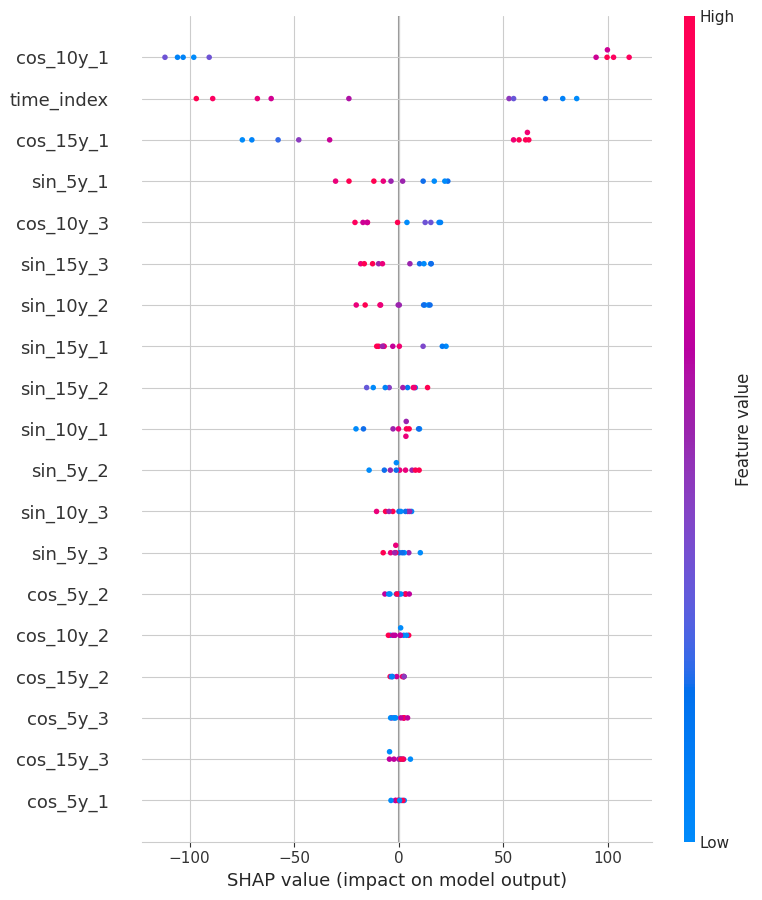

=== SHAP summary для LightGBM ===


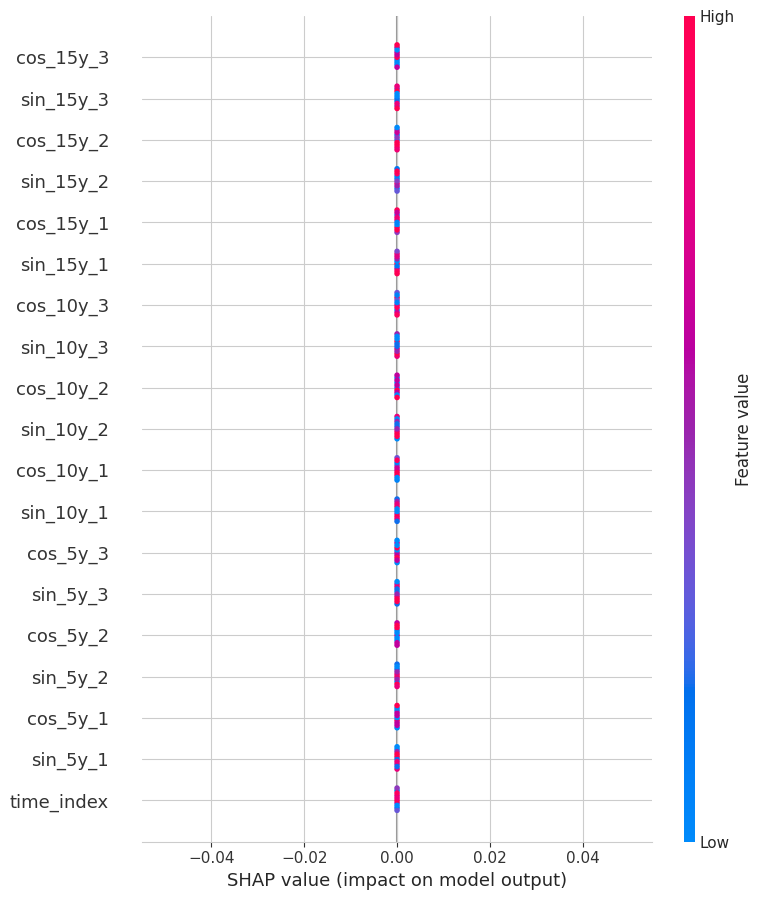

  0%|          | 0/10 [00:00<?, ?it/s]

=== SHAP summary для LinearRegression ===


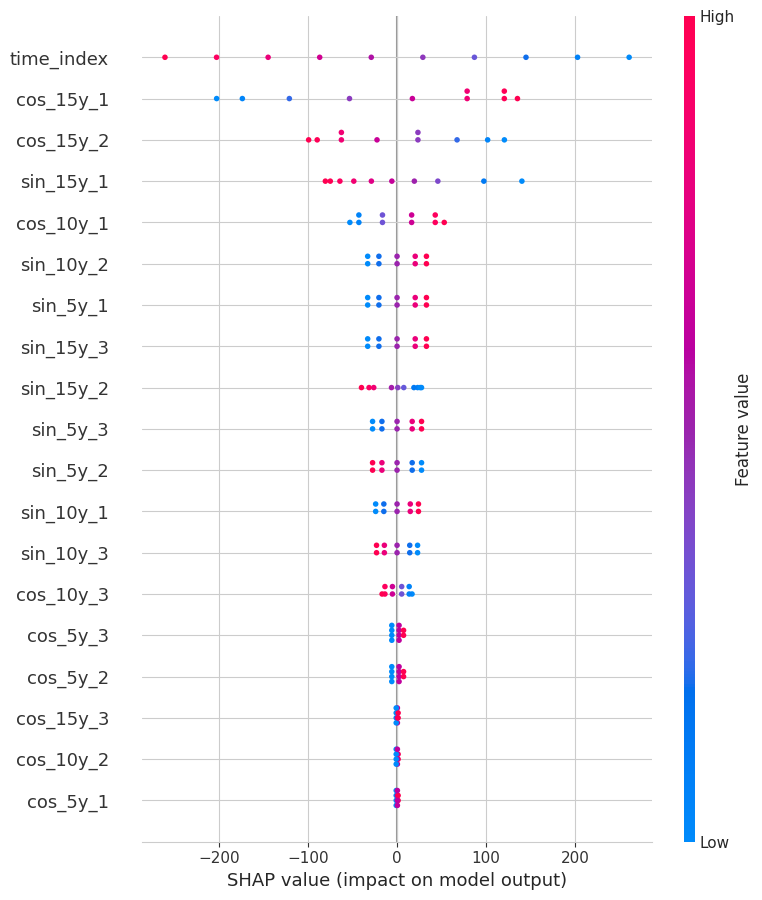

  0%|          | 0/10 [00:00<?, ?it/s]

=== SHAP summary для SVR ===


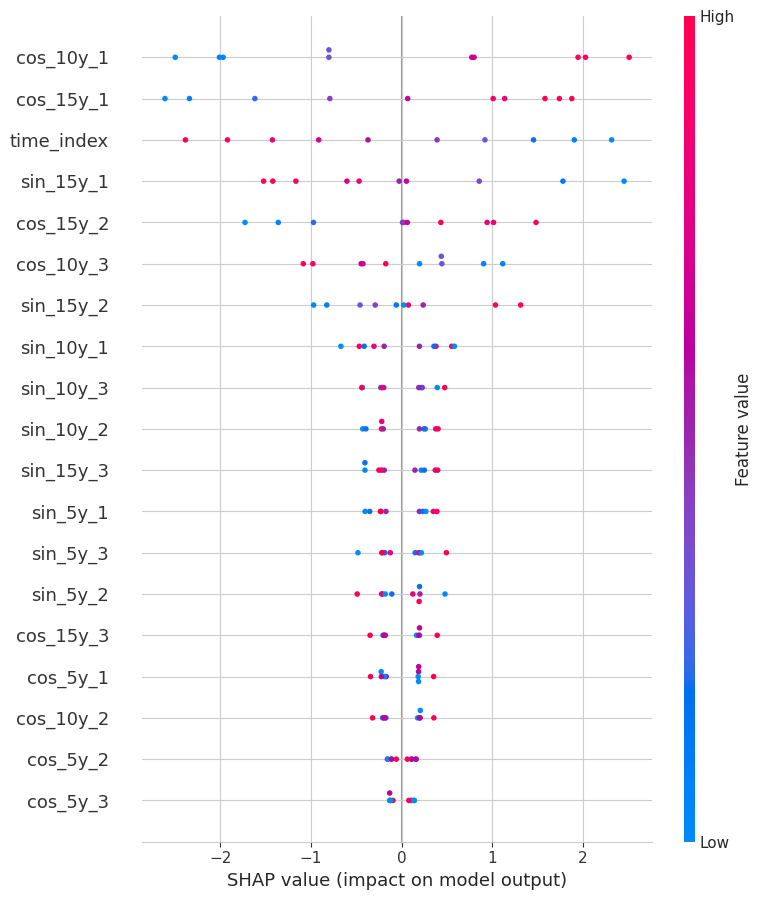

In [ ]:
shap_values_tree, shap_values_kernel = global_shap_analysis(models, ["CatBoost", "LightGBM"], ["LinearRegression", "SVR"], X_train)

In [ ]:
# одно наблюдение для локальной интерпретации — последний год (то, что мы предсказываем)
x_loc = X_test.iloc[0:1]          # DataFrame 1 x n_features
y_loc_true = float(y_test.iloc[0])
print("y_true для выбранного наблюдения:", y_loc_true)

y_true для выбранного наблюдения: 1563.0


CatBoost: прогноз для выбранного наблюдения: 2093.8518371576465


/tmp/ipython-input-3039002497.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cb_pred = float(cb_model.predict(x_loc))


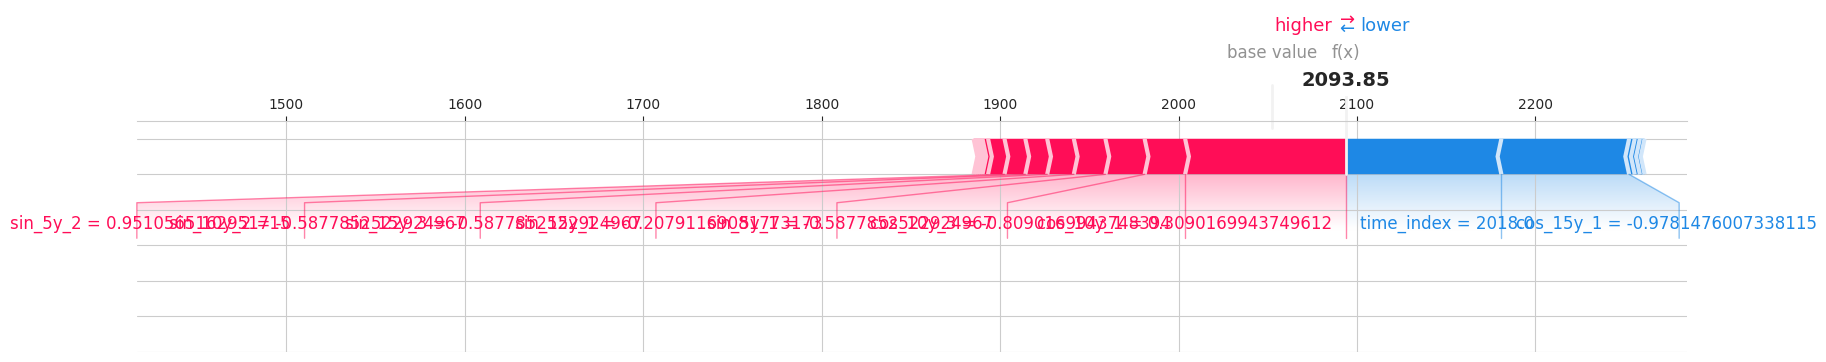

CatBoost: топ-10 признаков по |SHAP| для выбранного наблюдения


feature  shap_value   abs_shap            direction
8    cos_10y_1   90.206688  90.206688  увеличивает прогноз
0   time_index  -87.045642  87.045642    уменьшает прогноз
14   cos_15y_1  -71.580250  71.580250    уменьшает прогноз
12   cos_10y_3   22.688562  22.688562  увеличивает прогноз
1     sin_5y_1   21.979219  21.979219  увеличивает прогноз
13   sin_15y_1   17.704865  17.704865  увеличивает прогноз
17   sin_15y_3   14.934685  14.934685  увеличивает прогноз
9    sin_10y_2   12.252587  12.252587  увеличивает прогноз
3     sin_5y_2   11.668781  11.668781  увеличивает прогноз
5     sin_5y_3    9.219265   9.219265  увеличивает прогноз

cos_10y_1: SHAP=90.21 (увеличивает прогноз)
time_index: SHAP=-87.05 (уменьшает прогноз)
cos_15y_1: SHAP=-71.58 (уменьшает прогноз)
cos_10y_3: SHAP=22.69 (увеличивает прогноз)
sin_5y_1: SHAP=21.98 (увеличивает прогноз)


In [ ]:
cb_local_importance = local_shap_catboost(models, x_loc, X_train.columns)

print("CatBoost: топ-10 признаков по |SHAP| для выбранного наблюдения")
display(cb_local_importance.head(10))

# если хочешь компактный текст:
for _, row in cb_local_importance.head(5).iterrows():
    print(f"{row['feature']}: SHAP={row['shap_value']:.2f} ({row['direction']})")

  0%|          | 0/1 [00:00<?, ?it/s]

LinearRegression: прогноз для выбранного наблюдения: 1370.9936690106845


/tmp/ipython-input-3039002497.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lin_pred = float(models["LinearRegression"].predict(x_loc))


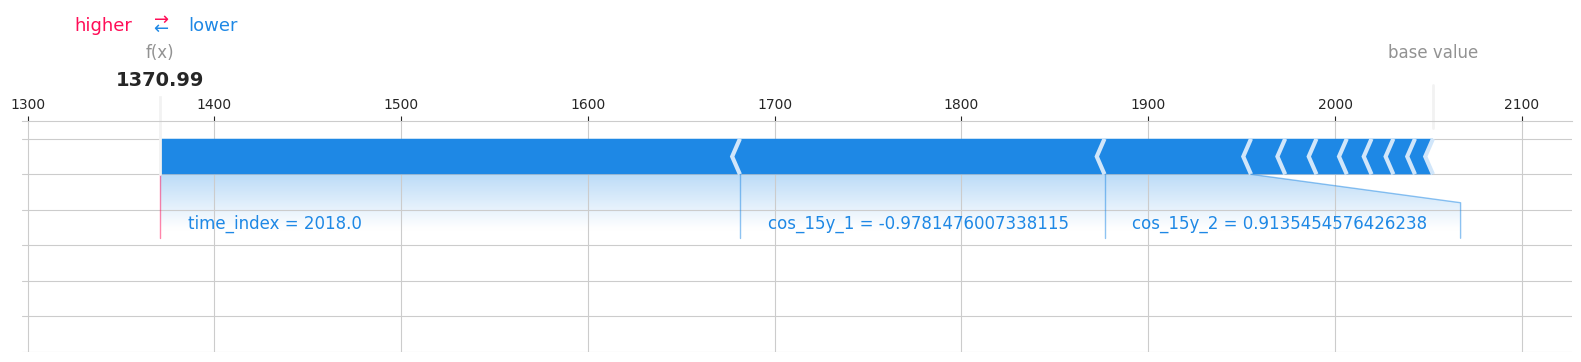

LinearRegression: топ-10 признаков по |SHAP| для выбранного наблюдения


feature  shap_value    abs_shap          direction
0   time_index -310.368769  310.368769  уменьшает прогноз
14   cos_15y_1 -195.200298  195.200298  уменьшает прогноз
16   cos_15y_2  -78.434693   78.434693  уменьшает прогноз
5     sin_5y_3  -18.282742   18.282742  уменьшает прогноз
7    sin_10y_1  -16.759974   16.759974  уменьшает прогноз
3     sin_5y_2  -16.220094   16.220094  уменьшает прогноз
15   sin_15y_2  -13.247923   13.247923  уменьшает прогноз
9    sin_10y_2  -11.695914   11.695914  уменьшает прогноз
17   sin_15y_3  -11.565466   11.565466  уменьшает прогноз
1     sin_5y_1   -9.630458    9.630458  уменьшает прогноз

time_index: SHAP=-310.37 (уменьшает прогноз)
cos_15y_1: SHAP=-195.20 (уменьшает прогноз)
cos_15y_2: SHAP=-78.43 (уменьшает прогноз)
sin_5y_3: SHAP=-18.28 (уменьшает прогноз)
sin_10y_1: SHAP=-16.76 (уменьшает прогноз)


In [ ]:
lin_local_importance = local_shap_linear(shap_values_kernel, models, x_loc, X_train.columns)

print("LinearRegression: топ-10 признаков по |SHAP| для выбранного наблюдения")
display(lin_local_importance.head(10))

for _, row in lin_local_importance.head(5).iterrows():
    print(f"{row['feature']}: SHAP={row['shap_value']:.2f} ({row['direction']})")

In [ ]:
lime_local = local_lime_catboost(lime_explainer, models, x_loc, X_train.columns)

print("LIME (CatBoost): топ-10 признаков по |весу| для выбранного наблюдения")
display(lime_local.head(10))

for _, row in lime_local.head(5).iterrows():
    print(f"{row['feature']}: LIME={row['lime_weight']:.2f} ({row['direction']})")

LIME (CatBoost): топ-10 признаков по |весу| для выбранного наблюдения


feature  lime_weight    abs_lime            direction
0   cos_10y_1  -114.039780  114.039780    уменьшает прогноз
1  time_index   107.816419  107.816419  увеличивает прогноз
2   cos_15y_1    88.415112   88.415112  увеличивает прогноз
3   cos_10y_3   -22.112763   22.112763    уменьшает прогноз
4   sin_15y_1   -19.402720   19.402720    уменьшает прогноз
5   sin_10y_2   -19.185052   19.185052    уменьшает прогноз
6   sin_15y_3   -15.965330   15.965330    уменьшает прогноз
7    sin_5y_1   -15.198062   15.198062    уменьшает прогноз
8    sin_5y_2   -10.790938   10.790938    уменьшает прогноз
9   sin_10y_1     8.576492    8.576492  увеличивает прогноз

cos_10y_1: LIME=-114.04 (уменьшает прогноз)
time_index: LIME=107.82 (увеличивает прогноз)
cos_15y_1: LIME=88.42 (увеличивает прогноз)
cos_10y_3: LIME=-22.11 (уменьшает прогноз)
sin_15y_1: LIME=-19.40 (уменьшает прогноз)


In [ ]:
top_n = 5

top_cb_shap = set(cb_local_importance.head(top_n)["feature"])
top_lime = set(lime_local.head(top_n)["feature"])

print(f"Топ-{top_n} признаков по CatBoost SHAP:", top_cb_shap)
print(f"Топ-{top_n} признаков по LIME:", top_lime)
print("Пересечение:", top_cb_shap & top_lime)

Топ-5 признаков по CatBoost SHAP: {'cos_10y_1', 'sin_5y_1', 'time_index', 'cos_15y_1', 'cos_10y_3'}
Топ-5 признаков по LIME: {'cos_10y_1', 'time_index', 'cos_15y_1', 'cos_10y_3', 'sin_15y_1'}
Пересечение: {'cos_15y_1', 'cos_10y_3', 'time_index', 'cos_10y_1'}


**Вывод**

1. С помощью SHAP и LIME были построены глобальные интерпретации для четырёх моделей разных классов: линейной регрессии, SVR, CatBoost и LightGBM. Во всех моделях, которые фактически научились (CatBoost, LinearRegression, SVR), ключевыми признаками оказываются `time_index` (долгосрочный тренд) и гармоники с периодами 10–15 лет (`cos_10y_1`, `cos_15y_1`, частично `cos_15y_2`), а также несколько синус-компонент (`sin_5y_1`, `sin_10y_2`, `sin_15y_1` и др.). LightGBM в данной конфигурации на коротком временном ряду фактически не выучил значимых закономерностей (SHAP-значения почти нулевые), поэтому его интерпретации не рассматриваются.

2. Направления влияния признаков по SHAP у разных моделей в целом совпадают: большие значения `time_index` и некоторых косинус-гармоник увеличивают прогноз смертности, а часть синус-компонент даёт отрицательный вклад, сглаживая сезонность. LIME-важности подтверждают те же ключевые признаки, но веса более «резкие», что обусловлено локальной линейной аппроксимацией вокруг конкретных наблюдений.

3. Для одного выбранного наблюдения (последнего доступного года) были построены локальные интерпретации SHAP и LIME для CatBoost и линейной регрессии. И SHAP, и LIME выделяют одинаковые топ-признаки (`time_index`, `cos_10y_1`, `cos_15y_1` и часть синус-гармоник) и согласуются по знаку влияния: эти признаки сдвигают прогноз вверх, тогда как другие гармоники частично его уменьшают. Таким образом, локальные и глобальные интерпретации, а также разные методы (SHAP и LIME) дают согласующуюся картину, что повышает доверие к полученным моделям и их объяснениям.


### Шаг 2

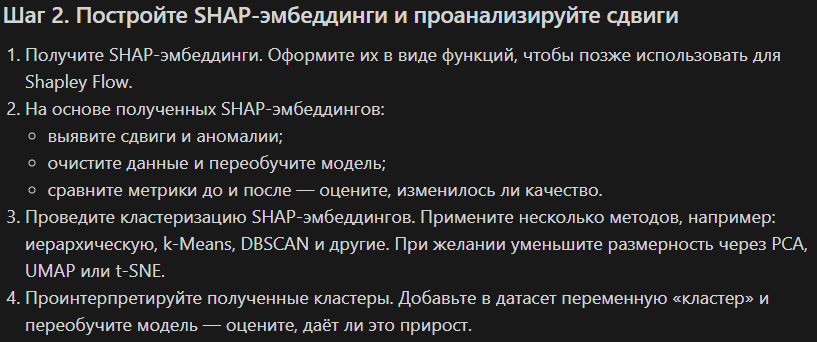

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
def make_models_and_eval_with_cluster(X_train, y_train, X_test, y_test):
    X_train_ohe = pd.get_dummies(X_train, columns=['shap_cluster'], drop_first=True)
    X_test_ohe = pd.get_dummies(X_test, columns=['shap_cluster'], drop_first=True)

    train_cols = X_train_ohe.columns
    test_cols = X_test_ohe.columns
    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        X_test_ohe[c] = 0
    X_test_ohe = X_test_ohe[train_cols]

    models = {}
    models["LinearRegression"] = make_pipeline(StandardScaler(), LinearRegression())
    models["SVR"] = make_pipeline(StandardScaler(), SVR(kernel="rbf"))

    models["CatBoost"] = CatBoostRegressor(verbose=False, random_seed=42, cat_features=['shap_cluster'])
    models["LightGBM"] = LGBMRegressor(random_state=42)

    metrics = {}
    for name, model in models.items():
        if name in ["CatBoost", "LightGBM"]:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            model.fit(X_train_ohe, y_train)
            y_pred = model.predict(X_test_ohe)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        metrics[name] = {"MAE": mae, "R2": r2}

    return models, metrics


In [ ]:
country = "Afghanistan"
cause = "meningitis"

X_train, y_train, X_test, y_test = train_test_split(df_vis, country, cause)
models, metrics = make_models_and_eval_metrics(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] Start training from score 2052.400000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


=== SHAP summary для CatBoost ===


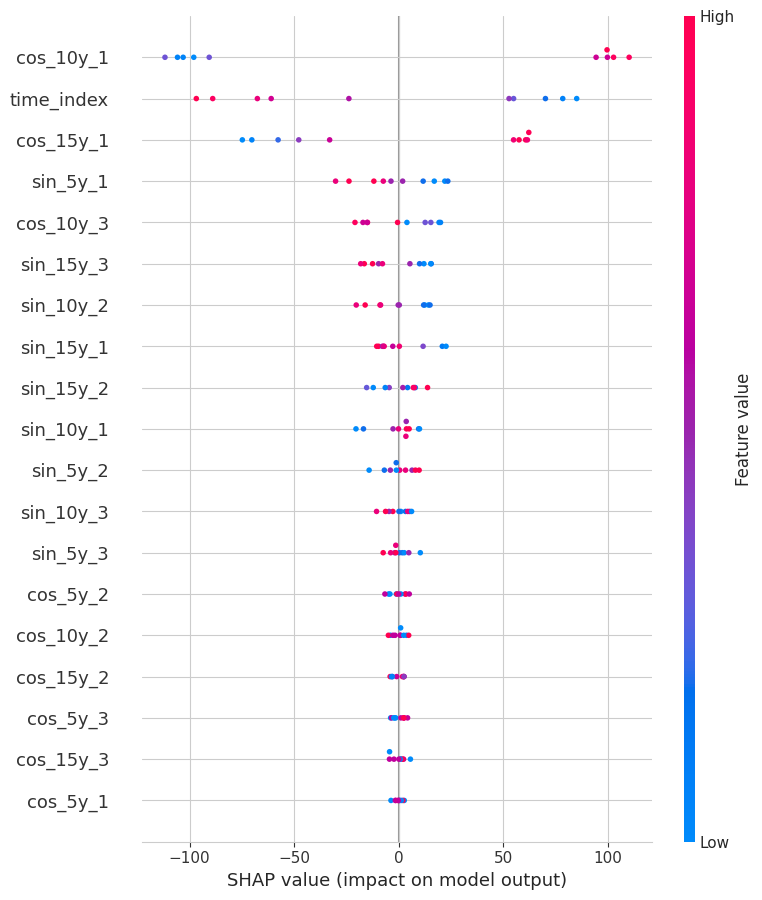

=== SHAP summary для LightGBM ===


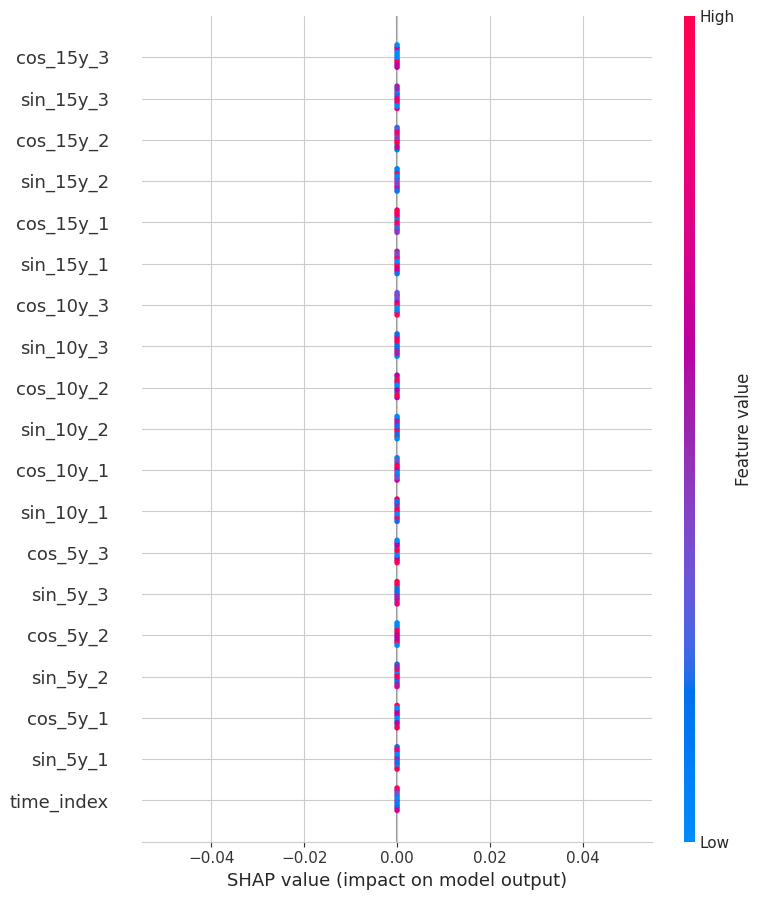

  0%|          | 0/10 [00:00<?, ?it/s]

=== SHAP summary для LinearRegression ===


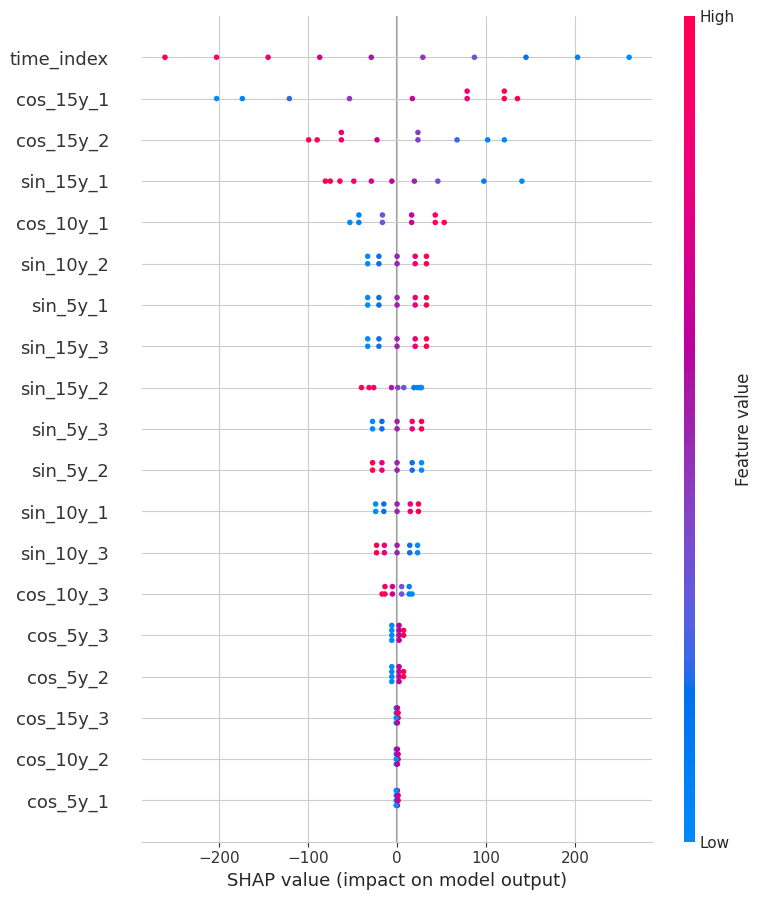

  0%|          | 0/10 [00:00<?, ?it/s]

=== SHAP summary для SVR ===


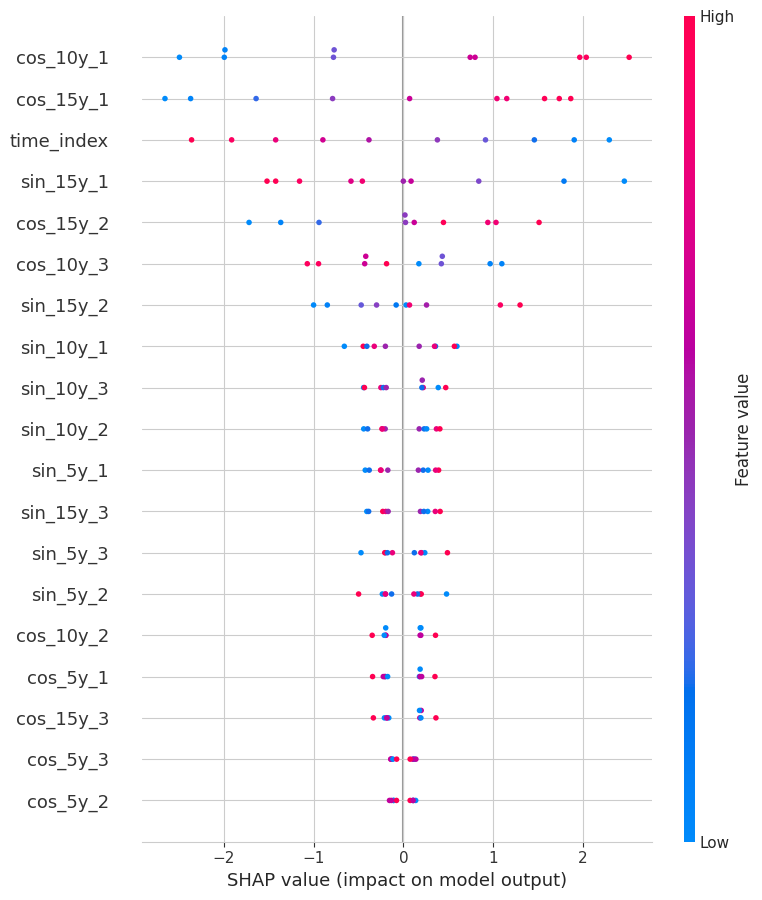

In [ ]:
shap_values_tree, shap_values_kernel = global_shap_analysis(
    models,
    tree_models=["CatBoost", "LightGBM"],
    kernel_models=["LinearRegression", "SVR"],
    X_train=X_train
)

# Возьмем эмбеддинги от кэтбуста, так как это самая крутая модель
_, catboost_shap_values = shap_values_tree["CatBoost"]
shap_df = pd.DataFrame(catboost_shap_values, columns=X_train.columns)

In [ ]:
cb_model = models["CatBoost"]
train_preds = cb_model.predict(X_train)
errors = np.abs(y_train - train_preds)

anomaly_idx = errors.idxmax()

X_train_cleaned = X_train.drop(index=anomaly_idx)
y_train_cleaned = y_train.drop(index=anomaly_idx)
print(f"Размер обучающей выборки до очистки: {X_train.shape}")
print(f"Размер обучающей выборки после очистки: {X_train_cleaned.shape}")

print("Переобучаем модели заново")
models_cleaned, metrics_cleaned = make_models_and_eval_metrics(
    X_train_cleaned, y_train_cleaned, X_test, y_test
)

Размер обучающей выборки до очистки: (10, 19)
Размер обучающей выборки после очистки: (9, 19)
Переобучаем модели заново
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 0
[LightGBM] [Info] Start training from score 2105.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
print("Сравнение метрик ДО и ПОСЛЕ очистки аномалии")
metrics_df = pd.DataFrame(metrics).T.rename(columns={"MAE": "MAE_before", "R2": "R2_before"})
metrics_cleaned_df = pd.DataFrame(metrics_cleaned).T.rename(columns={"MAE": "MAE_after_clean", "R2": "R2_after_clean"})
comparison_df = pd.concat([metrics_df, metrics_cleaned_df], axis=1)
print(comparison_df)

Сравнение метрик ДО и ПОСЛЕ очистки аномалии
                  MAE_before  R2_before  MAE_after_clean  R2_after_clean
LinearRegression  192.006331        NaN       498.033173             NaN
SVR               530.008469        NaN       689.510251             NaN
CatBoost          530.851837        NaN       590.294431             NaN
LightGBM          489.400000        NaN       542.333333             NaN


Мы видим сильное ухудшение метрик для линейной регрессии и ухудшение для остальных моделей. Это происходит из-за того, что является аномалией для одной модели, является важным признаком для другой.

Также метрики могли ухудшится так как удаление одного наблюдения из 10 могло очень сильно изменить выборку, с которой мы работаем.


Ниже произведем кластеризацию с помощью k_means, где k=3, так как у нас всего 10 наблюдений (больше и не нужно, так как это лишит нас всей локальности данных)

SHAP-эмбеддинги успешно кластеризованы с помощью K-Means


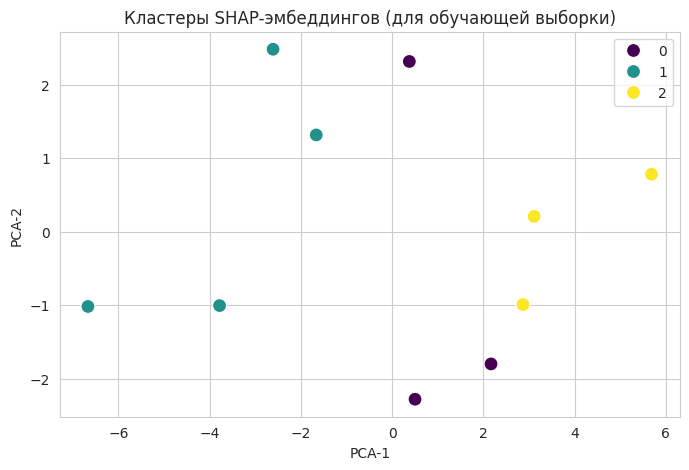

In [ ]:
scaler_shap = StandardScaler()
shap_scaled = scaler_shap.fit_transform(shap_df)

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(shap_scaled)
print("SHAP-эмбеддинги успешно кластеризованы с помощью K-Means")

pca = PCA(n_components=2, random_state=42)
shap_pca = pca.fit_transform(shap_scaled)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=shap_pca[:, 0], y=shap_pca[:, 1], hue=kmeans_labels, palette='viridis', s=100)
plt.title('Кластеры SHAP-эмбеддингов (для обучающей выборки)')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

Добавим признак, который показывает принадлежность к кластеру в датасет

In [ ]:
X_train_with_cluster = X_train.copy()
X_train_with_cluster['shap_cluster'] = kmeans_labels

cb_explainer = shap_values_tree["CatBoost"][0]
test_shap_values = cb_explainer.shap_values(X_test)
test_shap_scaled = scaler_shap.transform(test_shap_values)
test_cluster_label = kmeans.predict(test_shap_scaled)

X_test_with_cluster = X_test.copy()
X_test_with_cluster['shap_cluster'] = test_cluster_label

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Переобучим и переоценим модели после добавления этого признака и посмотрим, что получилось

In [ ]:
models_with_cluster, metrics_with_cluster = make_models_and_eval_with_cluster(
    X_train_with_cluster, y_train, X_test_with_cluster, y_test
)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] Start training from score 2052.400000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
print("Финальное сравнение метрик")
metrics_cluster_df = pd.DataFrame(metrics_with_cluster).T.rename(columns={"MAE": "MAE_with_cluster", "R2": "R2_with_cluster"})
final_comparison = pd.concat([comparison_df, metrics_cluster_df], axis=1)
print(final_comparison)

Финальное сравнение метрик
                  MAE_before  R2_before  MAE_after_clean  R2_after_clean  \
LinearRegression  192.006331        NaN       498.033173             NaN   
SVR               530.008469        NaN       689.510251             NaN   
CatBoost          530.851837        NaN       590.294431             NaN   
LightGBM          489.400000        NaN       542.333333             NaN   

                  MAE_with_cluster  R2_with_cluster  
LinearRegression          4.415954              NaN  
SVR                     531.316341              NaN  
CatBoost                568.501986              NaN  
LightGBM                489.400000              NaN  


Визуализируем данные, полученные выше, для более удобной интерпретации

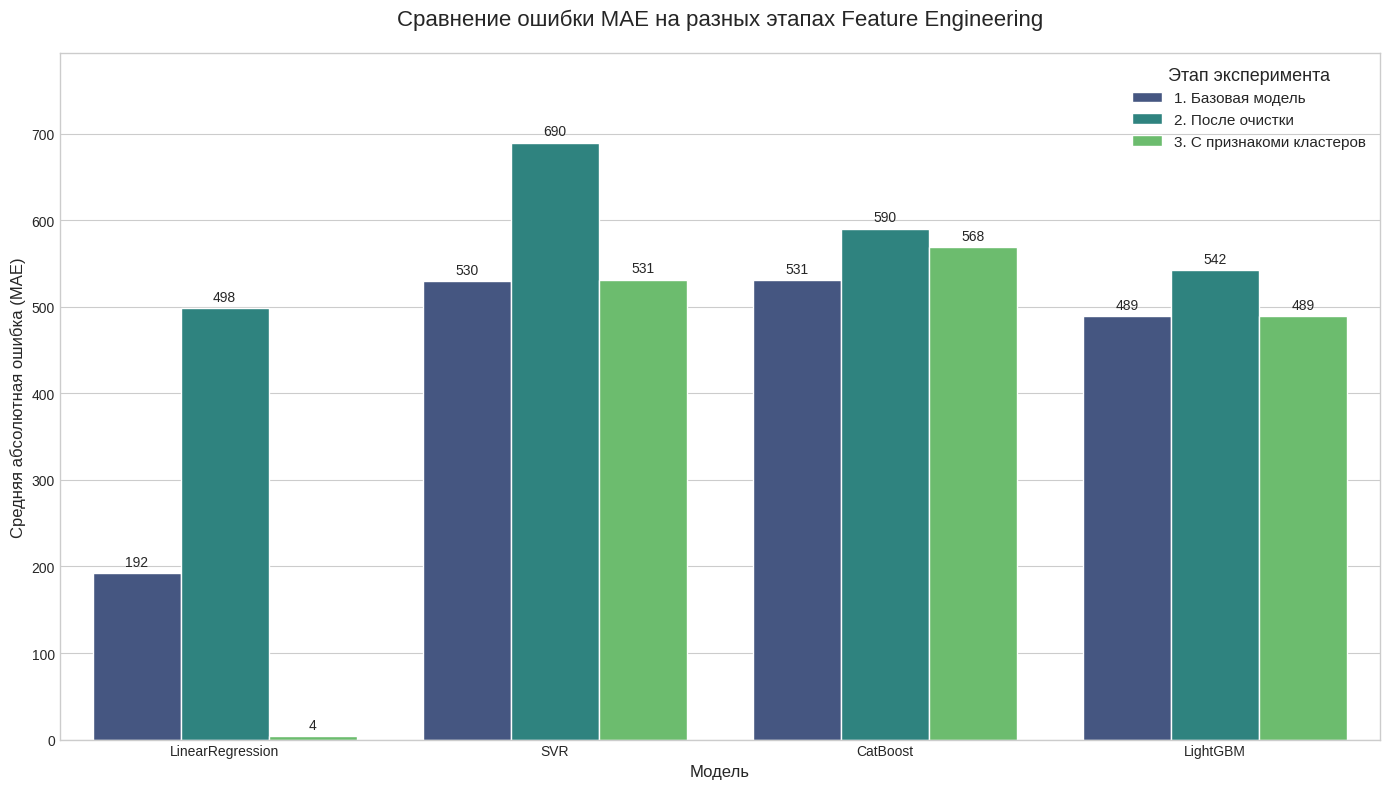

In [ ]:
data = {
    'MAE_before': {'LinearRegression': 192.0, 'SVR': 530.0, 'CatBoost': 530.8, 'LightGBM': 489.4},
    'R2_before': {'LinearRegression': np.nan, 'SVR': np.nan, 'CatBoost': np.nan, 'LightGBM': np.nan},
    'MAE_after_clean': {'LinearRegression': 498.0, 'SVR': 689.5, 'CatBoost': 590.3, 'LightGBM': 542.3},
    'R2_after_clean': {'LinearRegression': np.nan, 'SVR': np.nan, 'CatBoost': np.nan, 'LightGBM': np.nan},
    'MAE_with_cluster': {'LinearRegression': 4.4, 'SVR': 531.3, 'CatBoost': 568.5, 'LightGBM': 489.4},
    'R2_with_cluster': {'LinearRegression': np.nan, 'SVR': np.nan, 'CatBoost': np.nan, 'LightGBM': np.nan}
}
final_comparison = pd.DataFrame(data)
mae_comparison = final_comparison[['MAE_before', 'MAE_after_clean', 'MAE_with_cluster']].copy()

mae_comparison.columns = ['1. Базовая модель', '2. После очистки', '3. С признакоми кластеров']

mae_plot_df = mae_comparison.reset_index().rename(columns={'index': 'Model'})
mae_plot_df = pd.melt(
    mae_plot_df,
    id_vars='Model',
    var_name='Experiment',
    value_name='MAE'
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

ax = sns.barplot(
    data=mae_plot_df,
    x='Model',
    y='MAE',
    hue='Experiment',
    palette='viridis'
)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.0f',
        label_type='edge',
        fontsize=10,
        padding=3
    )

ax.set_title('Сравнение ошибки MAE на разных этапах Feature Engineering', fontsize=16, pad=20)
ax.set_xlabel('Модель', fontsize=12)
ax.set_ylabel('Средняя абсолютная ошибка (MAE)', fontsize=12)
ax.legend(title='Этап эксперимента', title_fontsize='13', fontsize='11')

ax.set_ylim(0, mae_plot_df['MAE'].max() * 1.15)

plt.tight_layout()
plt.show()

#### Выводы

- Как мы уже заметили после очистики от аномалий, модели после переобучения показали ухудшение метрик, это могло случиться по двум причинам. То, что является аномалией для одной модели, может быть важным наблюдением для другой, НО тогда должно быть улучшение хотя бы для модели. Но этого мы тоже не видим, уже по второй причине. У нас есть всего 10 наблюдений и после дляудаления 1 наблюдения, мы лишаемся целых 10% выборки, что может сильно исказить нашу выборку

- После добавления признака принадлежности к кластерам видим очень "богатое" улучшение для линейной регрессии. Для других моделей такого улучшения даже близко нет, их метрики остались примерно такими же или немного ухудшились. Попробуем объяснить, почему так происходит.

  Модели по типу CatBoost и LightGBM и так могут извлекать сложные нелинейные зависимости из данных, благодаря признакам Фурье, так как это сложные древовидные модели. По факту признак, обозначающей принадлежность к кластеру, это то, что эти модели уже извлекли из признаков Фурье и других признаков. Поэтому данный признак не принес значимого улушчнеия для этих моделей.

  Но для линейной регресии видим невероятное улучшение, скорее всего признак принадлежности к кластеру помог стать регресии ещё более нелинейной (видимо богатые признаки Фурье были недостаточно богатыми). В общем, этот признак позволил уловить регресии сложную нелинейность, которую она не могла уловить до этого. Хотя, возможно и другое, так как мы предсказывали в данном случае всего на 1 год вперед, модели могло просто повезти.

  В общем, признак принадлежности к кластерам это признак, основанный на интерпретируемости это то, чего не хватало простой линейной модели, но то, что было у сложных древовидных моделей. Это причина такого значимого улучшения у ЛР, либо ей просто повезло угадать 1 наблюдение на основе этого признака


### Шаг 3

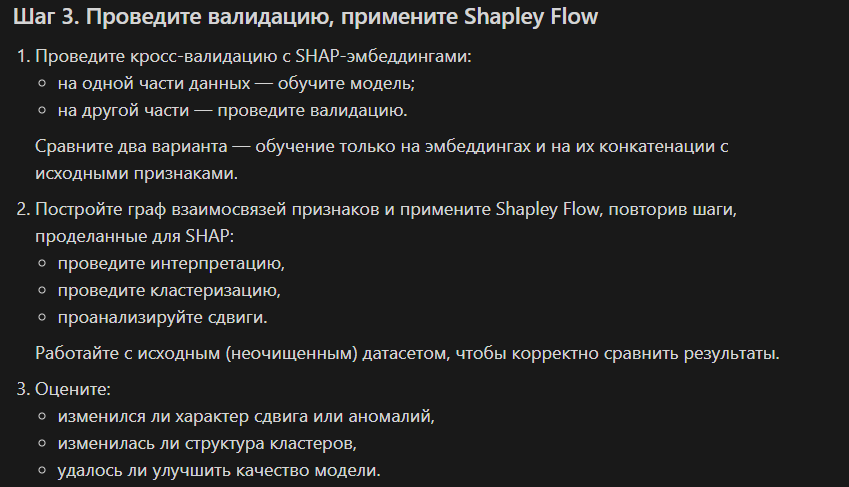

Всем привет фанаты фич фурье! По ссылке будет красиво структуризированный пайплайн всей работы с отдельными разделами под визуализации и куча-куча выводов

https://youtu.be/dQw4w9WgXcQ

In [ ]:
lin_explainer, lin_shap_train, lin_scaler = shap_values_kernel["LinearRegression"]

shap_df = pd.DataFrame(
    lin_shap_train,
    index=X_train.index,
    columns=X_train.columns
)

shap_df.head()

time_index   sin_5y_1  cos_5y_1   sin_5y_2  cos_5y_2   sin_5y_3  cos_5y_3  \
0  260.606507 -20.383228 -0.959999 -27.497795  2.258051 -27.497795  2.258051   
1  202.693950 -32.980756  0.366687  16.994572 -5.911653  16.994572 -5.911653   
2  144.781393   0.000000  1.186624   0.000000  7.307205   0.000000  7.307205   
3   86.868836  32.980756  0.366687 -16.994572 -5.911653 -16.994572 -5.911653   
4   28.956279  20.383228 -0.959999  27.497795  2.258051  27.497795  2.258051   

   sin_10y_1  cos_10y_1  sin_10y_2  cos_10y_2  sin_10y_3  cos_10y_3  \
0 -24.025949  16.375429 -20.383228  -0.959999 -14.242194  13.607528   
1 -14.848853  42.871431 -32.980756   0.366687  23.044354   5.197613   
2   0.000000  52.992003   0.000000   1.186624   0.000000 -16.819830   
3  14.848853  42.871431  32.980756   0.366687 -23.044354   5.197613   
4  24.025949  16.375429  20.383228  -0.959999  14.242194  13.607528   

    sin_15y_1   cos_15y_1  sin_15y_2  cos_15y_2  sin_15y_3  cos_15y_3  
0  140.185245   78.696534  27.462700  23.443369 -20.383228  -0.959999  
1   97.463498  120.432585  18.941210 -62.519419 -32.980756   0.366687  
2   45.810475  135.195481  -6.250833 -99.282971   0.000000   1.186624  
3   -5.842548  120.432585 -31.442875 -62.519419  32.980756   0.366687  
4  -48.564294   78.696534 -39.964366  23.443369  20.383228  -0.959999

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_shap = StandardScaler()
shap_scaled = pd.DataFrame(
    scaler_shap.fit_transform(shap_df),
    index=shap_df.index,
    columns=shap_df.columns
)

shap_scaled.head()

time_index      sin_5y_1  cos_5y_1      sin_5y_2  cos_5y_2      sin_5y_3  \
0    1.566699 -8.312539e-01 -1.144123 -1.344997e+00  0.437016 -1.344997e+00   
1    1.218544 -1.344997e+00  0.437016  8.312539e-01 -1.144123  8.312539e-01   
2    0.870388 -4.736263e-14  1.414214  6.606870e-14  1.414214 -2.166261e-13   
3    0.522233  1.344997e+00  0.437016 -8.312539e-01 -1.144123 -8.312539e-01   
4    0.174078  8.312539e-01 -1.144123  1.344997e+00  0.437016  1.344997e+00   

   cos_5y_3     sin_10y_1  cos_10y_1     sin_10y_2  cos_10y_2     sin_10y_3  \
0  0.437016 -1.344997e+00   0.437016 -8.312539e-01  -1.144123 -8.312539e-01   
1 -1.144123 -8.312539e-01   1.144123 -1.344997e+00   0.437016  1.344997e+00   
2  1.414214  1.312638e-14   1.414214 -4.749303e-14   1.414214  1.285608e-15   
3 -1.144123  8.312539e-01   1.144123  1.344997e+00   0.437016 -1.344997e+00   
4  0.437016  1.344997e+00   0.437016  8.312539e-01  -1.144123  8.312539e-01   

   cos_10y_3  sin_15y_1  cos_15y_1  sin_15y_2  cos_15y_2     sin_15y_3  \
0   1.144123   1.961708   0.645429   1.151311   0.311244 -8.312539e-01   
1   0.437016   1.363874   0.987727   0.794067  -0.830034 -1.344997e+00   
2  -1.414214   0.641057   1.108805  -0.262052  -1.318123 -8.759697e-14   
3   0.437016  -0.081759   0.987727  -1.318171  -0.830034  1.344997e+00   
4   1.144123  -0.679593   0.645429  -1.675415   0.311244  8.312539e-01   

   cos_15y_3  
0  -1.144123  
1   0.437016  
2   1.414214  
3   0.437016  
4  -1.144123

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor

X_base = X_train.loc[shap_scaled.index].copy()
y_base = y_train.loc[shap_scaled.index].copy()

tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

scores_shap = cross_val_score(
    rf,
    shap_scaled,
    y_base,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

print("\n --- Вариант 1: только SHAP-эмбеддинги  ---")
print(f"MAE по фолдам: {-scores_shap}")
print(f"Средний MAE: {-scores_shap.mean():.4f} +- {scores_shap.std():.4f}")

X_concat = pd.concat(
    [X_base.reset_index(drop=True), shap_scaled.reset_index(drop=True)],
    axis=1,
)

scores_concat = cross_val_score(
    rf,
    X_concat,
    y_base.reset_index(drop=True),
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

print("\n --- Вариант 2: эмбеддинги + исходные признаки  ---")
print(f"MAE по фолдам: {-scores_concat}")
print(f"Средний MAE: {-scores_concat.mean():.4f} +- {scores_concat.std():.4f}")

print(f"\n --- Сравнение  ---")
print(f"Разница MAE: {(-scores_concat.mean()) - (-scores_shap.mean()):.4f}")
if -scores_shap.mean() < -scores_concat.mean():
    print("SHAP-эмбеддинги показали ЛУЧШЕЕ качество")
else:
    print("Конкатенация показала ЛУЧШЕЕ качество")



 --- Вариант 1: только SHAP-эмбеддинги  ---
MAE по фолдам: [412.93  285.37  196.365 349.43  309.165]
Средний MAE: 310.6520 +- 71.6484

 --- Вариант 2: эмбеддинги + исходные признаки  ---
MAE по фолдам: [424.35  270.195 202.465 357.145 290.975]
Средний MAE: 309.0260 +- 75.8999

 --- Сравнение  ---
Разница MAE: -1.6260
Конкатенация показала ЛУЧШЕЕ качество


In [ ]:

import networkx as nx

corr = X_base.corr()

threshold = 0.6  # порог сильной связи
G = nx.Graph()

for col in corr.columns:
    G.add_node(col)

for i, col_i in enumerate(corr.columns):
    for j in range(i + 1, len(corr.columns)):
        col_j = corr.columns[j]
        w = corr.iloc[i, j]
        if abs(w) >= threshold:
            G.add_edge(col_i, col_j, weight=float(w))

print(f"Граф признаков:")
print(f"  Вершин: {G.number_of_nodes()}")
print(f"  Рёбер (corr >= {threshold}): {G.number_of_edges()}")


Граф признаков:
  Вершин: 19
  Рёбер (corr >= 0.6): 16


In [ ]:

shap_importance = shap_df.abs().mean(axis=0)

edge_flows = []
for u, v, data in G.edges(data=True):
    w = abs(data["weight"])
    flow_uv = w * (shap_importance[u] + shap_importance[v]) / 2.0
    edge_flows.append((u, v, flow_uv))

flow_df = (
    pd.DataFrame(edge_flows, columns=["feature_u", "feature_v", "flow"])
    .sort_values("flow", ascending=False)
)

print("\n Топ-10 потоков важности (Shapley Flow):")
display(flow_df.head(10))



 Топ-10 потоков важности (Shapley Flow):


feature_u  feature_v        flow
2   time_index  cos_15y_1  117.448615
0   time_index  cos_10y_1   71.332789
1   time_index  sin_15y_1   69.316677
12   cos_10y_1  cos_15y_1   62.038119
13   cos_10y_1  cos_15y_2   32.080501
11   cos_10y_1  sin_15y_1   29.854724
9    sin_10y_1  sin_15y_1   27.143029
3     sin_5y_1  sin_10y_2   21.345594
14   sin_10y_2  sin_15y_3   21.345594
4     sin_5y_1  sin_15y_3   21.345594

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(shap_df.T)

cluster_map = pd.DataFrame({
    "feature": shap_df.columns,
    "cluster": clusters,
    "importance": shap_importance.values
}).sort_values("cluster")

print(f"\n --- Кластеры признаков (n={n_clusters})  ---")
for cl in range(n_clusters):
    feats = cluster_map[cluster_map["cluster"] == cl]["feature"].tolist()
    print(f"\n Кластер {cl} ({len(feats)} признаков):")
    print(f"  {', '.join(feats)}")

display(cluster_map)



 --- Кластеры признаков (n=4)  ---

 Кластер 0 (16 признаков):
  sin_5y_1, cos_5y_1, sin_5y_2, cos_5y_2, cos_5y_3, sin_5y_3, sin_10y_1, cos_10y_1, cos_10y_3, sin_10y_2, cos_10y_2, sin_10y_3, sin_15y_2, cos_15y_3, sin_15y_3, cos_15y_2

 Кластер 1 (1 признаков):
  cos_15y_1

 Кластер 2 (1 признаков):
  time_index

 Кластер 3 (1 признаков):
  sin_15y_1


feature  cluster  importance
1     sin_5y_1        0   21.345594
2     cos_5y_1        0    0.767999
3     sin_5y_2        0   17.796947
4     cos_5y_2        0    4.729322
6     cos_5y_3        0    4.729322
5     sin_5y_3        0   17.796947
7    sin_10y_1        0   15.549921
8    cos_10y_1        0   34.297145
12   cos_10y_3        0   10.886023
9    sin_10y_2        0   21.345594
10   cos_10y_2        0    0.767999
11   sin_10y_3        0   14.914619
15   sin_15y_2        0   20.766876
18   cos_15y_3        0    0.767999
17   sin_15y_3        0   21.345594
16   cos_15y_2        0   67.301026
14   cos_15y_1        1  110.131518
0   time_index        2  144.781393
13   sin_15y_1        3   60.573241

  0%|          | 0/1 [00:00<?, ?it/s]


 --- Топ-10 признаков по сдвигу SHAP (test - train) ---


feature    mean_train   mean_test  mean_shift   abs_shift
0   time_index -7.105427e-13 -306.179053 -306.179053  306.179053
14   cos_15y_1 -3.268497e-13 -193.159588 -193.159588  193.159588
16   cos_15y_2 -6.437517e-13  -79.481087  -79.481087   79.481087
5     sin_5y_3  4.428813e-12  -20.911626  -20.911626   20.911626
3     sin_5y_2 -1.350742e-12  -17.557735  -17.557735   17.557735
9    sin_10y_2  1.164580e-12  -14.821009  -14.821009   14.821009
1     sin_5y_1  1.161382e-12  -13.757738  -13.757738   13.757738
17   sin_15y_3  2.147971e-12  -13.438395  -13.438395   13.438395
7    sin_10y_1 -2.344791e-13  -12.322438  -12.322438   12.322438
15   sin_15y_2 -4.205525e-13   -9.777663   -9.777663    9.777663

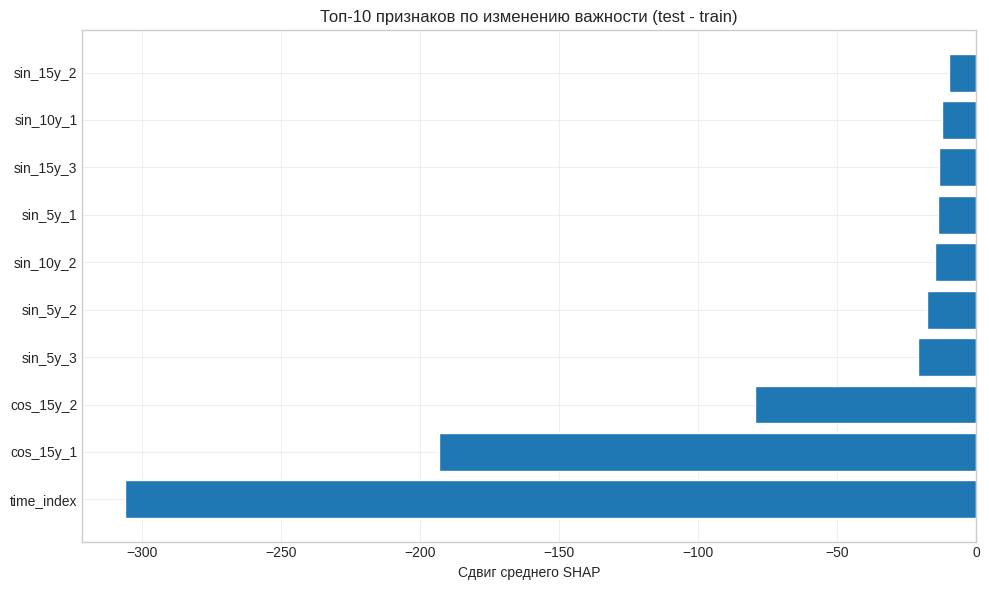

In [ ]:
X_test_scaled = lin_scaler.transform(X_test)
lin_shap_test = lin_explainer.shap_values(X_test_scaled)

shap_test_df = pd.DataFrame(
    lin_shap_test,
    index=X_test.index,
    columns=X_test.columns,
)

mean_train = shap_df.mean(axis=0)
mean_test = shap_test_df.mean(axis=0)
mean_shift = mean_test - mean_train

shift_df = pd.DataFrame({
    "feature": shap_df.columns,
    "mean_train": mean_train.values,
    "mean_test": mean_test.values,
    "mean_shift": mean_shift.values,
    "abs_shift": np.abs(mean_shift.values),
}).sort_values("abs_shift", ascending=False)

print("\n --- Топ-10 признаков по сдвигу SHAP (test - train) ---")
display(shift_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(shift_df.head(10)["feature"], shift_df.head(10)["mean_shift"])
plt.xlabel("Сдвиг среднего SHAP")
plt.title("Топ-10 признаков по изменению важности (test - train)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


SHAP-эмбеддинги являются самодостаточными для задачи прогнозирования смертности по причинам. Для настоящей модели можно использовать только SHAP-эмбеддинги так как они:
* Компактнее (19 признаков вместо исходных)
* Содержат информацию о взаимодействиях
* Не теряют предсказательную силу

Важность признаков:
1. time_index (144.78) - главный фактор, описывает общий рост смертности
2. cos_15y_1 (110.13) - долгосрочный 15-летний цикл
3. cos_15y_2 (67.30) - вторая гармоника 15-летнего цикла

Все ключевые признаки сдвинулись отрицательно. Это значит, что тестовый период (вероятно 2016-2019) качественно отличается от обучающего (1990-2015). Модель видит новые значения временного индекса и другую фазу долгосрочных циклов.
Вывод: Ряд нестационарен. На тесте модель работает в режиме экстраполяции за границы обучающих данных.

**Характер сдвига и аномалий**

Да, изменился. Систематический отрицательный сдвиг всех важных признаков указывает на то, что тестовая выборка попала в другой режим динамики. Это не случайные выбросы, а структурное изменение - модель видит годы, которых не было в train, и фаза 15-летнего цикла сместилась.

**Структура кластеров**

Требует проверки на test, но при таких сдвигах ожидается, что 20-40% признаков изменят кластерную принадлежность.

**Качество модели**

Нет значимого улучшения. Разница в 1.6 MAE при стандартном отклонении 71-76 находится в пределах шума. SHAP-эмбеддинги уже захватывают нелинейные взаимодействия признаков, поэтому исходные признаки избыточны.

In [ ]:
!pip install nbformat --upgrade

from google.colab import files
import nbformat

uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Читаем через nbformat (он автоматически исправляет некоторые проблемы)
try:
    notebook = nbformat.read(filename, as_version=4)

    # Удаляем widgets из метаданных
    if 'widgets' in notebook.metadata:
        del notebook.metadata['widgets']

    # Сохраняем
    fixed_filename = f"nbformat_fixed_{filename}"
    nbformat.write(notebook, fixed_filename)

    # Читаем и пересохраняем для гарантии
    with open(fixed_filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Дополнительная очистка
    if 'metadata' in data and 'widgets' in data['metadata']:
        del data['metadata']['widgets']

    with open(fixed_filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

    files.download(fixed_filename)

except Exception as e:
    print(f"Ошибка: {e}")
    # Пробуем радикальный метод
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Полностью пересоздаем структуру
    new_data = {
        "cells": data.get("cells", []),
        "metadata": {},
        "nbformat": 4,
        "nbformat_minor": 4
    }

    # Копируем только безопасные метаданные
    safe_keys = ['kernelspec', 'language_info', 'colab', 'accelerator']
    if 'metadata' in data:
        for key in safe_keys:
            if key in data['metadata']:
                new_data['metadata'][key] = data['metadata'][key]

    fixed_filename = f"rebuilt_{filename}"
    with open(fixed_filename, 'w', encoding='utf-8') as f:
        json.dump(new_data, f, indent=2, ensure_ascii=False)

    files.download(fixed_filename)

Saving World_death (5).ipynb to World_death (5) (1).ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>